## Objective
Run algorithm on spikeinterface recording

si_rec12.ipynb -> si_rec13.ipynb: Final version of code for final draft of first RT-Sort manuscript
- si_rec13.ipynb --> si_rec13_patch.ipynb: Running on patch clamp data

## Globals setup

In [1]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1

env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [2]:
%load_ext autoreload

In [3]:
from copy import deepcopy
from importlib import reload
from multiprocessing import Pool
import shutil
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

# Only for testing
from diptest import diptest

%autoreload 2
from src import utils, recording
from src.run_alg import si_rec13 as F  # This forces you to manually reload every time modification happens (prevents forgetfulness errors)
from src.sorters.base import Unit

In [4]:
# Load recording
# PATCH_ROOT = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602")
# PATCH_PATHS = [
#     PATCH_ROOT / "patch_rec_cell2.raw.h5",
#     # PATCH_ROOT / "patch_rec_cell3.raw.h5",
#     # PATCH_ROOT / "patch_rec_cell4.raw.h5",
#     # PATCH_ROOT / "patch_rec_cell6A.raw.h5",
#     # PATCH_ROOT / "patch_rec_cell6B.raw.h5",
#     # PATCH_ROOT / "patch_rec_cell7.raw.h5"
# ]

# # MEA 2602
PATCH = "/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cell2.raw.h5"  # pre-recording (the patch failed)
# PATCH = "/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cell3.raw.h5"  # cell 3
# PATCH = "/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cell7.raw.h5"  # cell 7

# # MEA 1916
# PATCH = '/data/MEAprojects/primary_mouse/patch_ground_truth/181115/1916/MEA_rec_patch_cell1.raw.h5 ' # cell 1
# PATCH = '/data/MEAprojects/primary_mouse/patch_ground_truth/181115/1916/MEA_rec_patch_cell3.raw.h5 ' # cell 3

# # Patches that do not work (too noisy)
# PATCH = "/data/MEAprojects/primary_mouse/patch_ground_truth/190614/2047/MEA_rec_patch_cell3.raw.h5"
# PATCH = "/data/MEAprojects/primary_mouse/patch_ground_truth/191113/2179/MEA_rec_patch_cell2.raw.h5"
# PATCH = "/data/MEAprojects/primary_mouse/patch_ground_truth/190412/2051/MEA_pre_rec.raw.h5"
# PATCH = "/data/MEAprojects/primary_mouse/patch_ground_truth/190412/2051/MEA_rec_patch_cell1.raw.h5 "
# PATCH = "/data/MEAprojects/primary_mouse/patch_ground_truth/210226/3117/MEA_rec_patch_cell1.raw.h5 "

##
PATCH_PATHS = [Path(PATCH)]
PATCH_ROOT = PATCH_PATHS[0].parent

# # If using all recordings for an MEA
# PATCH_ROOT = "/data/MEAprojects/primary_mouse/patch_ground_truth/181115/1916"
# PATCH_PATHS = [file for file in Path(PATCH_ROOT).iterdir() if str(file).strip().endswith(".h5")]

from spikeinterface.extractors import MaxwellRecordingExtractor
from spikeinterface import concatenate_recordings

recordings = []
patch_start_min = 0
for patch_path in PATCH_PATHS:
    patch = MaxwellRecordingExtractor(patch_path)
    
    # Only select valid channels
    elec_locs = patch.get_channel_locations()
    valid_ids = [id for i, id in enumerate(patch.get_channel_ids()) if np.all(elec_locs[i] != -1)]
    patch = patch.channel_slice(valid_ids, list(range(len(valid_ids))))
    
    # filt_patch = scale(patch, patch.get_channel_gains(), patch.get_channel_offsets(), dtype="float16")
    # filt_patch = bandpass_filter(patch, freq_min=300, freq_max=3000, dtype="float16")
    duration = patch.get_total_duration()/60
    print(f"{patch_path.name.split('.')[0]}: duration: {duration:.2f} min, {patch_start_min:.2f}-{patch_start_min+duration:.2f} min")
    patch_start_min += duration
    recordings.append(patch)
    
    # print(len(valid_ids))
    
RECORDING = concatenate_recordings(recordings)
SAMP_FREQ = round(RECORDING.get_sampling_frequency() / 1000)  # kHz
NUM_ELECS = RECORDING.get_num_channels()
ELEC_LOCS = RECORDING.get_channel_locations()

assert SAMP_FREQ <= 35, "SAMP_FREQ must be in kHz"
if SAMP_FREQ not in {20, 30}:
    print("NEED TO CHANGE FRONT_BUFFER AND OUTPUT_WINDOW_HALF_SIZE TO MODEL'S VALUES")

patch_rec_cell2: duration: 20.15 min, 0.00-20.15 min


In [5]:
if RECORDING.get_total_duration() >= 5 * 60:  # Recording is greater than five minutes
    training_duration_ms = recordings[0].get_total_samples() / recordings[0].get_sampling_frequency() * 1000
    TRAINING_MS = (training_duration_ms - 5*60*1000, training_duration_ms)  # Last 5 minute of first patch
    TRACES_TRAINING_MS = (50, 5*60*1000)  # Rel to scaled_traces
else:
    TRAINING_MS = (0, RECORDING.get_total_duration() * 1000)
    TRACES_TRAINING_MS = (50, RECORDING.get_total_duration() * 1000)
    
TESTING_MS = (-1, -1)  # Not used for patch recordings
# TESTING_MS = (training_duration_ms, RECORDING.get_total_duration() * 1000)  # 5 min to 10 min in recording (in ms)

In [6]:
CELL = "cell2"  # If multiple recordings for one MEA (otherwise, put None)
ROOT_PATH = PATCH_ROOT / "rt_sort/240318"
ROOT_PATH_MODEL = PATCH_ROOT / "rt_sort/dl_model/230101"
# ROOT_PATH = PATCH_ROOT / "rt_sort/240318_speed_test_240327"
# ROOT_PATH_MODEL = PATCH_ROOT / "rt_sort/dl_model/230101_speed_test_240327"
if CELL is not None:
    ROOT_PATH = ROOT_PATH / CELL
    ROOT_PATH_MODEL = ROOT_PATH_MODEL / CELL

MODEL_PATH = Path("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876")

STRINGENT_THRESH = 0.275
STRINGENT_THRESH_LOGIT = F.sigmoid_inverse(STRINGENT_THRESH)
LOOSE_THRESH = 0.1 
LOOSE_THRESH_LOGIT = F.sigmoid_inverse(LOOSE_THRESH)

INFERENCE_SCALING_NUMERATOR = 12.6 

FRONT_BUFFER = round(2*SAMP_FREQ)
OUTPUT_WINDOW_HALF_SIZE = round(3*SAMP_FREQ)
PRE_MEDIAN_FRAMES = round(50 * SAMP_FREQ)

## No user inputs below
ROOT_PATH.mkdir(exist_ok=True, parents=True)
ROOT_PATH_MODEL.mkdir(exist_ok=True, parents=True)

SCALED_TRACES_PATH = ROOT_PATH_MODEL / "scaled_traces.npy"

MODEL_TRACES_PATH = ROOT_PATH_MODEL / "model_traces.npy"
MODEL_OUTPUTS_PATH = ROOT_PATH_MODEL / "model_outputs.npy" 

ALL_CROSSINGS_PATH  = ROOT_PATH_MODEL / "all_crossings.npy"
ELEC_CROSSINGS_IND_PATH = ROOT_PATH_MODEL / "elec_crossings_ind.npy"

print(ROOT_PATH)
print(ROOT_PATH_MODEL)

/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240318/cell2
/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/dl_model/230101/cell2


In [7]:
F.RECORDING = RECORDING
F.NUM_ELECS = NUM_ELECS
F.ELEC_LOCS = ELEC_LOCS
F.SAMP_FREQ = SAMP_FREQ
F.FRONT_BUFFER = FRONT_BUFFER
F.INFERENCE_SCALING_NUMERATOR = INFERENCE_SCALING_NUMERATOR
F.PRE_MEDIAN_FRAMES = PRE_MEDIAN_FRAMES

In [8]:
# For RT-Sort manuscript: measure time to detect sequences
import time

class Stopwatch:
    def __init__(self):
        self.duration = 0
        self.start_time = 0
    def start(self):
        self.start_time = time.time()
    def stop(self):
        stop_time = time.time()
        self.duration += stop_time - self.start_time

stopwatch = Stopwatch()

In [9]:
stopwatch.start()

# No user inputs here. Run after running DL model
ALL_CLOSEST_ELECS = []
for elec in range(NUM_ELECS):
    elec_ind = []
    dists = []
    x1, y1 = ELEC_LOCS[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = ELEC_LOCS[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    ALL_CLOSEST_ELECS.append(np.array(elec_ind)[order])   
# 
TRACES = np.load(MODEL_TRACES_PATH, mmap_mode="r")
FILT_TRACES = np.load(SCALED_TRACES_PATH, mmap_mode="r")  # called FILT_TRACES, but these are not actually filtered
OUTPUTS = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")
ALL_CROSSINGS = np.load(ALL_CROSSINGS_PATH, allow_pickle=True)
ELEC_CROSSINGS_IND = np.load(ELEC_CROSSINGS_IND_PATH, allow_pickle=True)

ALL_CROSSINGS = [tuple(cross) for cross in ALL_CROSSINGS]
ELEC_CROSSINGS_IND = [tuple(ind) for ind in ELEC_CROSSINGS_IND]  # [(elec's cross times ind in all_crossings)]

stopwatch.stop()

In [10]:
# Set global variables in .py
reload(F)

F.RECORDING = RECORDING
F.MEA = True
F.STRINGENT_THRESH = STRINGENT_THRESH
F.STRINGENT_THRESH_LOGIT = STRINGENT_THRESH_LOGIT
F.LOOSE_THRESH = LOOSE_THRESH
F.LOOSE_THRESH_LOGIT = LOOSE_THRESH_LOGIT
F.INFERENCE_SCALING_NUMERATOR = INFERENCE_SCALING_NUMERATOR

# F.CHANS_RMS = CHANS_RMS
F.SAMP_FREQ = SAMP_FREQ
F.NUM_ELECS = NUM_ELECS
F.ELEC_LOCS = ELEC_LOCS

F.ALL_CLOSEST_ELECS = ALL_CLOSEST_ELECS

F.FRONT_BUFFER = FRONT_BUFFER
F.OUTPUT_WINDOW_HALF_SIZE = OUTPUT_WINDOW_HALF_SIZE

F.N_BEFORE = F.N_AFTER = round(0.5 * SAMP_FREQ)  # Window for looking for electrode codetections
F.MIN_ELECS_FOR_ARRAY_NOISE = max(100, round(0.1 * NUM_ELECS))
F.MIN_ELECS_FOR_SEQ_NOISE = max(50, round(0.05 * NUM_ELECS))
F.PRE_MEDIAN_FRAMES = PRE_MEDIAN_FRAMES

F.MIN_ACTIVITY = 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000

# If doing on new recording, these should be set after ## Full run - DL model
F.TRACES = TRACES
F.OUTPUTS = OUTPUTS
F.ALL_CROSSINGS = ALL_CROSSINGS
F.ELEC_CROSSINGS_IND = ELEC_CROSSINGS_IND

# Different parameters for MEA
F.MIN_AMP_DIST_P = -1
F.MAX_AMP_MEDIAN_DIFF_SPIKES = F.MAX_AMP_MEDIAN_DIFF_SEQUENCES = 0.65
F.MAX_LATENCY_DIFF_SPIKES = F.MAX_LATENCY_DIFF_SEQUENCES = 3.5
F.CLIP_LATENCY_DIFF = 7
F.CLIP_AMP_MEDIAN_DIFF = 1.3
F.MAX_ROOT_AMP_MEDIAN_STD_SPIKES = 2.5
F.MAX_ROOT_AMP_MEDIAN_STD_SEQUENCES = np.inf

In [ ]:
# Plot all crossings on an elec as sanity check
elec = 731  # 731  # 731 for cell 3 in 181115/1916, 54 for cell 1 in 181115/1916
spikes = [ALL_CROSSINGS[idx][1] for idx in ELEC_CROSSINGS_IND[elec]]
F.plot_spikes(spikes, elec)
plt.show()

## Development

In [23]:
# form_from_root
root_elec=731

time_frame=TRACES_TRAINING_MS# TRAINING_MS
coc_clusters = F.form_coc_clusters(root_elec, time_frame, 
                                   verbose=True)
# F.setup_coc_clusters(coc_clusters, verbose=verbose)

Starting with elec 731, loc: [2607.5 2100. ]

Finding coocurrences


100%|██████████| 39/39 [00:00<00:00, 1521.68it/s]

20 cocs total

Unimodal amp/median with p-value: 0.082

Comparing to elec 607, loc: [2607.5 2082.5]


Found 1 clusters
4 cocs remaining

Ending early because too few cocs remaining

Total: 1 clusters


In [ ]:
merged_clusters = F.merge_coc_clusters(coc_clusters, verbose=True)

In [14]:
F.setup_coc_clusters(merged_clusters, verbose=True)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:22<00:00,  2.07s/it]


In [29]:
F.assign_spikes_gpu(merged_clusters, TRAINING_MS)

100%|██████████| 58804/58804 [00:54<00:00, 1080.51it/s]


In [71]:
F.assign_spikes(coc_clusters, time_frame, verbose=True)
print(len(coc_clusters))
coc_clusters = [c for c in coc_clusters if len(c._spike_train) >= 3]
print(len(coc_clusters))

100%|██████████| 4702764/4702764 [00:25<00:00, 181747.61it/s]

5
4


In [ ]:
merged_clusters = F.merge_coc_clusters(coc_clusters, verbose=True)

In [ ]:
use_formation_spike_train = False
use_filt = False  # If True, amp in footprint may not match histogram (histogram does not use filtered traces)

for i, cluster in enumerate(coc_clusters):    
    F.plot_elec_probs(cluster, idx=i, use_formation_spike_train=use_formation_spike_train, use_filt=use_filt)
    plt.show()
            
    amp_medians = F.get_amp_medians(cluster, n_cocs=None, use_formation_spike_train=use_formation_spike_train).flatten()
    plt.hist(amp_medians, bins=30)
    plt.show()
    
    print(f"dip p-val: {diptest(amp_medians)[1]:.3f}")

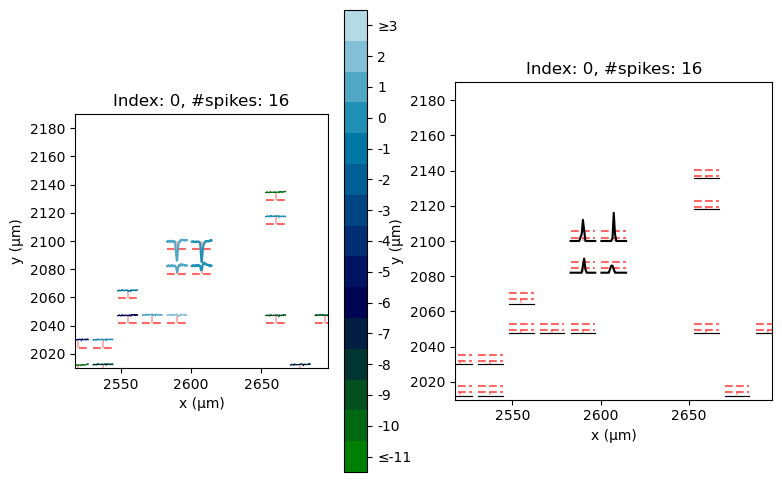

In [24]:
# cluster = root_elec_to_clusters[0][-1]
F.plot_elec_probs(coc_clusters[0])
plt.show()

# plt.hist(cluster.every_elec_prob[0, :])
# plt.show()

In [ ]:
spikes1 = []
spikes2 = []
for time, prob in zip(cluster.spike_train, cluster.every_elec_prob[0]):
    if prob < 0.1:
        spikes1.append(time)
    else:
        spikes2.append(time)
F.plot_spikes(spikes1, 0)
plt.show()
F.plot_spikes(spikes2, 0)
plt.show()

In [10]:
trained_sequences = utils.pickle_load("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240213/trained_sequences.pickle")

Max root dist: 17.50
Inner overlap: 3
Loose overlap: 3, 0.30
Latency diff: 1.05
Amp diff : 0.28
Elec 625 p-val: 0.00


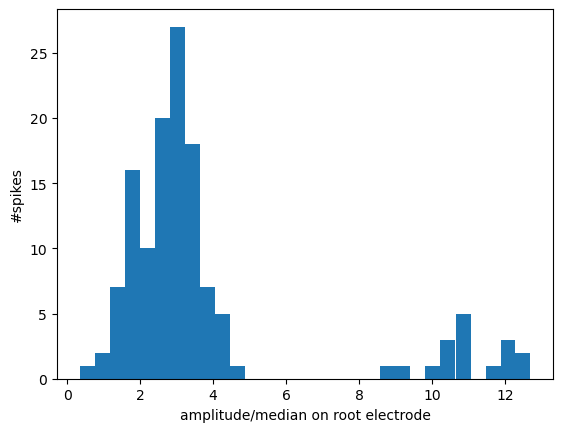

Elec 659 p-val: 0.00


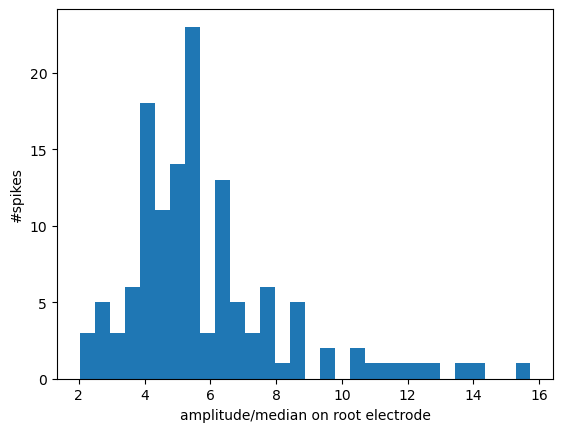

In [35]:
## Examine merge scores of seq pair
# cluster_i = SEQUENCES[9]
# cluster_j = SEQUENCES[10]
cluster_i = deepcopy(SEQUENCES[21])
cluster_i._spike_train = within_patch_spikes
F.setup_cluster(cluster_i)
cluster_j = SEQUENCES[23]

# F.plot_elec_probs(cluster_i)
# plt.show()
# F.plot_elec_probs(cluster_j)
# plt.show()

# amp_kwargs, prob_kwargs = F.plot_elec_probs(cluster_j)
# plt.show()
# F.plot_elec_probs(cluster_i, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
# plt.show()

max_dist = 0
for root_i in cluster_i.root_elecs:
    for root_j in cluster_j.root_elecs:
        max_dist = max(max_dist, F.calc_elec_dist(root_i, root_j))
print(f"Max root dist: {max_dist:.2f}")

total_loose = len(set(cluster_i.loose_elecs).union(cluster_j.loose_elecs))
num_loose_overlaps = len(set(cluster_i.loose_elecs).intersection(cluster_j.loose_elecs))
num_inner_loose_overlaps = len(set(cluster_i.inner_loose_elecs).intersection(cluster_j.inner_loose_elecs))
print(f"Inner overlap: {num_inner_loose_overlaps}")
print(f"Loose overlap: {num_loose_overlaps}, {num_loose_overlaps / total_loose:.2f}")

i_comp_elecs = cluster_i.comp_elecs
i_comp_elecs_set = set(i_comp_elecs)
j_comp_elecs = cluster_j.comp_elecs
comp_elecs = i_comp_elecs + [elec for elec in j_comp_elecs if elec not in i_comp_elecs_set]  # Prevents counting an elec more than once

# Get elec probs
i_elec_probs = cluster_i.all_elec_probs[comp_elecs]
j_elec_probs = cluster_j.all_elec_probs[comp_elecs]

# Compare latencies
i_latencies = cluster_i.all_latencies[comp_elecs][1:]
j_latencies = cluster_j.all_latencies[comp_elecs][1:] - cluster_j.all_latencies[comp_elecs[0]]  # Relative to same electrode as cluster_i
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=True)
latency_diff = np.abs(i_latencies - j_latencies)
latency_diff = np.clip(latency_diff, a_min=None, a_max=F.CLIP_LATENCY_DIFF)
latency_diff = np.sum(latency_diff * elec_weights)
print(f"Latency diff: {latency_diff:.2f}")

i_amp_medians = cluster_i.all_amp_medians[comp_elecs]
j_amp_medians = cluster_j.all_amp_medians[comp_elecs]                
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=False)
amp_median_div = (i_amp_medians + j_amp_medians) / 2
amp_median_diff = np.abs((i_amp_medians - j_amp_medians)) / amp_median_div
amp_median_diff = np.clip(amp_median_diff, a_min=None, a_max=F.CLIP_AMP_MEDIAN_DIFF)
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(f"Amp diff : {amp_median_diff:.2f}")

for root_elec in set(cluster_i.root_elecs + cluster_j.root_elecs):
    root_amps_i = cluster_i.every_amp_median[root_elec, :] # get_amp_medians(cluster_i, root_elec=root_elec)
    root_amps_j = cluster_j.every_amp_median[root_elec, :] # get_amp_medians(cluster_j, root_elec=root_elec)
    dip, pval = diptest(np.concatenate([root_amps_i, root_amps_j]))
    print(f"Elec {root_elec} p-val: {pval:.2f}")
    plt.hist(np.concatenate([root_amps_i, root_amps_j]), bins=30)
    plt.ylabel("#spikes")
    plt.xlabel("amplitude/median on root electrode")
    plt.show()

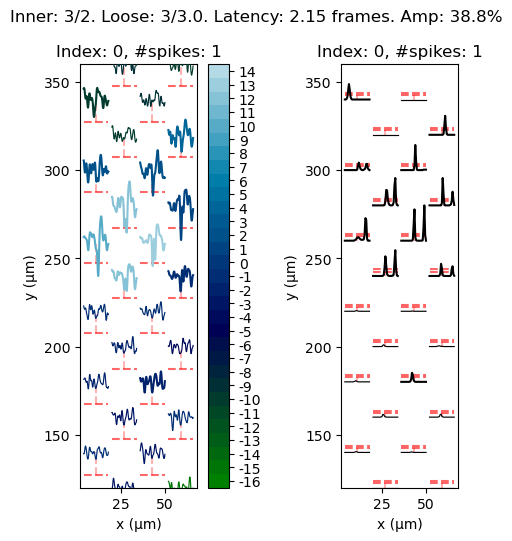

In [51]:
F.plot_seq_spike_overlap(tested_sequences[20], tested_sequences[20].spike_train[2895])
plt.show()

In [11]:
trained_sequences = utils.pickle_load("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240213/trained_sequences.pickle")

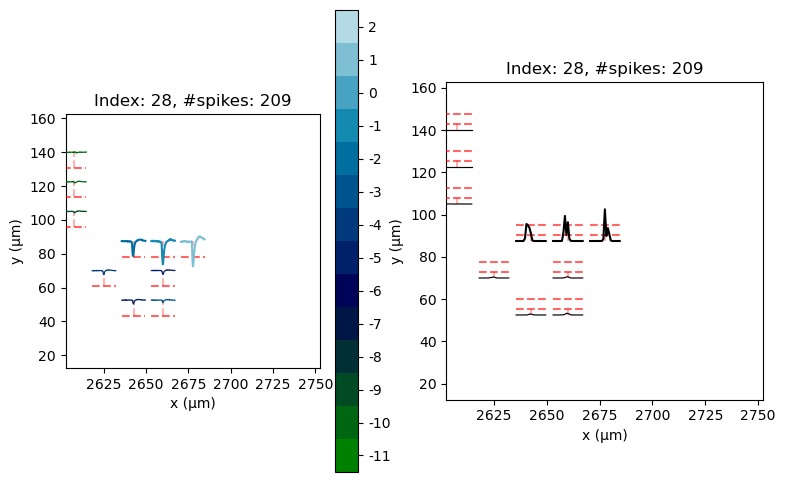

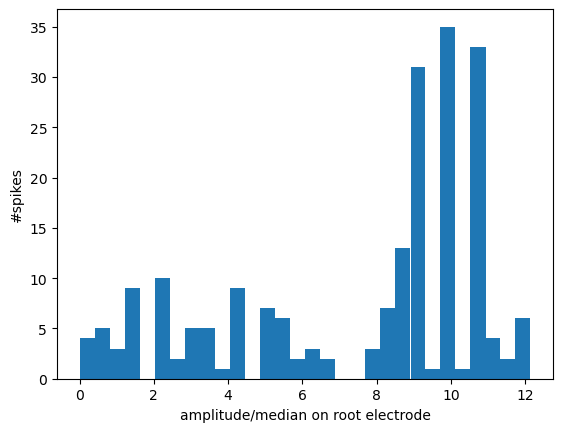

dip p-val: 0.000


In [27]:
use_formation_spike_train = False
use_filt = True  # If True, amp in footprint may not match histogram (histogram does not use filtered traces)

for i, cluster in enumerate([trained_sequences[28]]): 
    F.plot_elec_probs(cluster, idx=cluster.idx, use_formation_spike_train=use_formation_spike_train, use_filt=use_filt)
    plt.show()
            
    amp_medians = F.get_amp_medians(cluster, n_cocs=None, use_formation_spike_train=use_formation_spike_train).flatten()
    plt.hist(amp_medians, bins=30)
    plt.ylabel("#spikes")
    plt.xlabel("amplitude/median on root electrode")
    plt.show()
    
    print(f"dip p-val: {diptest(amp_medians)[1]:.3f}")

In [ ]:
# Split amp dist
seq = trained_sequences[28]
SPLIT_AMP = 7
spikes1 = []
amps1 = []
spikes2 = []
amps2 = []
for time, amp in zip(seq.formation_spike_train, F.get_amp_medians(seq, root_elec=seq.root_elec, use_formation_spike_train=True)):
    if amp < SPLIT_AMP:
        amps1.append(amp)
        spikes1.append(time)
    else:
        amps2.append(amp)
        spikes2.append(time)
plt.hist(amps1, bins=30)
plt.show()
F.plot_spikes(spikes1, seq.root_elec)
plt.show()
plt.hist(amps2, bins=30)
plt.show()
F.plot_spikes(spikes2, seq.root_elec)
plt.show()

In [13]:
test = F.get_amp_medians(seq, root_elec=seq.root_elec, use_formation_spike_train=True)

## Full run - DL model

In [9]:
stopwatch.start()
F.save_traces_mea_old(PATCH_PATHS[0], SCALED_TRACES_PATH, start_ms=TRAINING_MS[0], end_ms=TRAINING_MS[1])
stopwatch.stop()

Alllocating memory for traces ...
Extracting traces ...


100%|██████████| 60/60 [00:52<00:00,  1.15it/s]


In [10]:
from src.run_alg.model import ModelSpikeSorter
stopwatch.start()
model = ModelSpikeSorter.load(MODEL_PATH)
model.compile(NUM_ELECS, MODEL_PATH)
stopwatch.stop()

ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
Try decreasing the workspace size with IBuilderConfig::setMemoryPoolLimit().
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
Try decreasing the workspace size with IBuilderConfig::setMemoryPoolLimit().
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [Torch-TensorRT TorchScript Conversion Context] -

In [11]:
stopwatch.start()
F.run_dl_model(MODEL_PATH, SCALED_TRACES_PATH, MODEL_TRACES_PATH, MODEL_OUTPUTS_PATH)
stopwatch.stop()

Loading DL model ...
Allocating memory to save model traces and outputs ...


/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Inference scaling: 0.39375
Running model ...


100%|██████████| 49999/49999 [02:25<00:00, 344.67it/s]


In [12]:
stopwatch.start()
F.NUM_ELECS = NUM_ELECS
F.SAMP_FREQ = SAMP_FREQ
F.FRONT_BUFFER = FRONT_BUFFER
F.STRINGENT_THRESH = STRINGENT_THRESH
F.STRINGENT_THRESH_LOGIT = STRINGENT_THRESH_LOGIT
F.extract_crossings(MODEL_OUTPUTS_PATH, ALL_CROSSINGS_PATH, ELEC_CROSSINGS_IND_PATH)
stopwatch.stop()
print(f"Time to run DL model: {stopwatch.duration} seconds")

  0%|          | 18/5999 [00:00<01:08, 87.79it/s]

100%|██████████| 5999/5999 [01:03<00:00, 94.35it/s] 


Time to run DL model: 295.6675913333893 seconds


In [ ]:
# Sanity check that there are stringent detections
len(np.load(ALL_CROSSINGS_PATH, allow_pickle=True))

## Full run - sequences

In [15]:
stopwatch.start()

# ROOT_PATH = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240303")
# ROOT_PATH = PATCH_ROOT / "rt_sort/240303"
# ROOT_PATH.mkdir(exist_ok=True, parents=True)

MIN_SPIKES = max(10, 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000)

##
all_clusters = F.form_all_clusters(TRACES_TRAINING_MS)
# utils.pickle_dump(all_clusters, ROOT_PATH / "all_clusters.pickle")
# all_clusters = utils.pickle_load(ROOT_PATH / "all_clusters.pickle")

all_clusters_reassigned = F.reassign_spikes(all_clusters, TRACES_TRAINING_MS, MIN_SPIKES)
# utils.pickle_dump(all_clusters_reassigned, ROOT_PATH / "all_clusters_reassigned.pickle")
# all_clusters_reassigned = utils.pickle_load(ROOT_PATH / "all_clusters_reassigned.pickle")

intra_merged_clusters = F.intra_merge(all_clusters_reassigned) 
trained_sequences = F.inter_merge(intra_merged_clusters, MIN_SPIKES)
# utils.pickle_dump(trained_sequences, ROOT_PATH / "trained_sequences.pickle")
# trained_sequences = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")
stopwatch.stop()
print(f"Time to detect sequences: {stopwatch.duration} seconds")

# Save data
utils.pickle_dump(all_clusters, ROOT_PATH / "all_clusters.pickle")
utils.pickle_dump(all_clusters_reassigned, ROOT_PATH / "all_clusters_reassigned.pickle")
utils.pickle_dump(trained_sequences, ROOT_PATH / "trained_sequences.pickle")

SEQUENCES = trained_sequences  # around 50


 55%|█████▍    | 517/942 [00:31<00:26, 16.25it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
 56%|█████▌    | 525/942 [00:32<00:29, 14.16it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 71%|███████   | 670/942 [00:38<00:10, 26.67it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
 99%|█████████▉| 936/942 [00:51<00:00,  7.98it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
100%|█████████▉| 940/942 [00:55<00:01,  1.59it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/p

287 sequences before merging


100%|██████████| 63/63 [00:01<00:00, 34.74it/s]


69 sequences after first merging

Merged 58 with 16
Latency diff: 0.08. Amp median diff: 0.01
Amp dist p-value 0.0506
#spikes:
Merge base: 161, Add: 190, Overlaps: 140
After merging: 195

Merged 49 with 33
Latency diff: 0.04. Amp median diff: 0.05
Amp dist p-value 0.1620
#spikes:
Merge base: 124, Add: 88, Overlaps: 0
After merging: 211

Merged 17 with 63
Latency diff: 0.08. Amp median diff: 0.08
Amp dist p-value 0.2101
#spikes:
Merge base: 81, Add: 243, Overlaps: 2
After merging: 322

Merged 9 with 28
Latency diff: 0.11. Amp median diff: 0.09
Amp dist p-value 0.9546
#spikes:
Merge base: 101, Add: 43, Overlaps: 1
After merging: 143

Merged 22 with 46
Latency diff: 0.20. Amp median diff: 0.10
Amp dist p-value 1.7930
#spikes:
Merge base: 99, Add: 159, Overlaps: 4
After merging: 254

Merged 59 with 64
Latency diff: 0.19. Amp median diff: 0.10
Amp dist p-value 1.0078
#spikes:
Merge base: 118, Add: 190, Overlaps: 6
After merging: 303

Merged 54 with 42
Latency diff: 0.64. Amp median diff: 0.

In [ ]:
# # For MEA 2602
# for seq in F.get_nearby_clusters(trained_sequences, 2600, 600, 50):  # around cell 7
#     F.plot_elec_probs(seq)
#     plt.suptitle("Pre-recording")
#     plt.show()
# for seq in F.get_nearby_clusters(trained_sequences, 1960, 500, 50):  # around cell 4
#     F.plot_elec_probs(seq)
#     plt.suptitle("Pre-recording")
#     plt.show()
# for seq in F.get_nearby_clusters(trained_sequences, 1960, 420, 50):  # around cell 3
#     F.plot_elec_probs(seq)
#     plt.suptitle("Pre-recording")
#     plt.show()

### Run each part separately

In [12]:
# ROOT_PATH = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240303")
# ROOT_PATH = PATCH_ROOT / "rt_sort/240303"
# ROOT_PATH.mkdir(exist_ok=True, parents=True)

MIN_SPIKES = max(10, 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000)

In [ ]:
all_clusters = F.form_all_clusters(TRACES_TRAINING_MS)

In [16]:
utils.pickle_dump(all_clusters, ROOT_PATH / "all_clusters.pickle")

In [17]:
all_clusters = utils.pickle_load(ROOT_PATH / "all_clusters.pickle")

In [18]:
all_clusters_reassigned = F.reassign_spikes(all_clusters, TRACES_TRAINING_MS, MIN_SPIKES)

100%|██████████| 223/223 [00:12<00:00, 18.31it/s]


In [19]:
utils.pickle_dump(all_clusters_reassigned, ROOT_PATH / "all_clusters_reassigned.pickle")

In [20]:
all_clusters_reassigned = utils.pickle_load(ROOT_PATH / "all_clusters_reassigned.pickle")

In [ ]:
intra_merged_clusters = F.intra_merge(all_clusters_reassigned) 

In [ ]:
trained_sequences = F.inter_merge(intra_merged_clusters, MIN_SPIKES)

In [23]:
utils.pickle_dump(trained_sequences, ROOT_PATH / "trained_sequences.pickle")

In [14]:
trained_sequences = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")

### Analysis and reassigning spikes in pre-recording
SKIP!

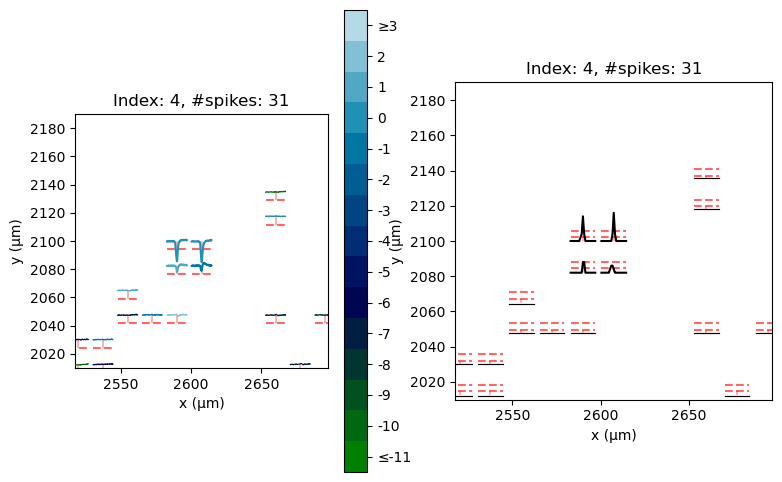

In [29]:
for seq in F.get_nearby_clusters(trained_sequences, *ELEC_LOCS[731], 100):
    F.plot_elec_probs(seq)
    plt.show()

In [ ]:
# F.assign_spikes_torch(trained_sequences, TRACES_TRAINING_MS)  #~:10 to setup, ~1:51 to run
# torch.cuda.empty_cache()

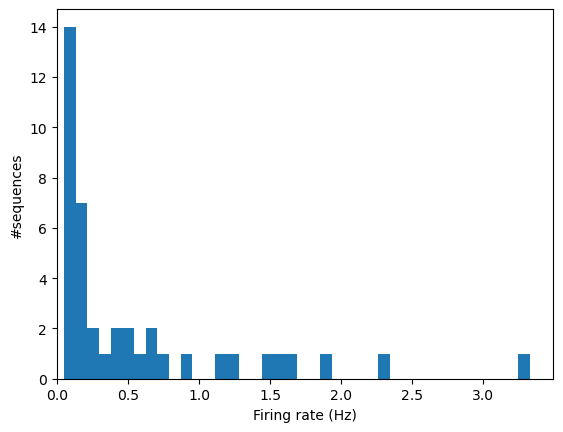

In [74]:
num_spikes = []
for seq in trained_sequences:
    num_spikes.append(len(seq.spike_train) / 300)
plt.hist(num_spikes, bins=40)#, range=(0, 2))
plt.xlim(0)#, 2)
plt.xlabel("Firing rate (Hz)")
plt.ylabel("#sequences")
plt.show()

In [ ]:
# Load kilosort units
from spikeinterface.extractors import MaxwellRecordingExtractor
maxwell = MaxwellRecordingExtractor("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602_old/pre_rec.raw.h5")
duration = maxwell.get_total_duration()
print(duration)
npz = np.load("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602_old/spikesort/results/chunk0/sorted.npz", allow_pickle=True)
firing_rates = []
for unit in npz["units"]:
    firing_rates.append(len(unit["spike_train"]) / duration)
plt.hist(firing_rates, bins=40, range=(0, 2))
plt.xlim(0, 2)
plt.ylabel("#units")
plt.xlabel("Firing rate (Hz)")
plt.show()

In [ ]:
use_formation_spike_train = True
use_filt = False  # If True, amp in footprint may not match histogram (histogram does not use filtered traces)

# np.random.seed(231) 
# for seq in np.random.choice(trained_sequences, 10):    
for seq in merged_sequences[20:]:
    F.plot_elec_probs(seq, idx=seq.idx, use_formation_spike_train=use_formation_spike_train, use_filt=use_filt)
    plt.show()
            
    amp_medians = F.get_amp_medians(seq, n_cocs=None, use_formation_spike_train=use_formation_spike_train).flatten()
    plt.hist(amp_medians, bins=30)
    plt.show()
    
    print(f"dip p-val: {diptest(amp_medians)[1]:.3f}")
    print(f"#loose elecs: {np.sum(seq.all_elec_probs >= F.LOOSE_THRESH)}")
    print(f"median root-amp: {np.median(seq.every_amp_median[seq.root_elec])}")

In [33]:
utils.pickle_dump(trained_sequences, ROOT_PATH / "tested_sequences.pickle")

In [ ]:
tested_sequences = utils.pickle_load(ROOT_PATH / "tested_sequences.pickle")

In [38]:
# tested_sequences = [seq for seq in tested_sequences if len(seq.spike_train) > 0]
# F.save_sequences_plots(tested_sequences, ROOT_PATH / "footprints")
F.save_sequences_plots(trained_sequences, ROOT_PATH / "trained_footprints")

100%|██████████| 41/41 [00:25<00:00,  1.64it/s]


In [33]:
prop_signal = F.clusters_to_sorter(tested_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, ROOT_PATH / "prop_signal.pickle")

### Find good-looking example of fully below 5SNR sequence

In [11]:
trained_sequences = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")

In [ ]:
# Find example
for seq in trained_sequences:
    if np.all(seq.all_amp_medians < 5):
        F.plot_elec_probs(seq)
        plt.show()

# for seq in trained_sequences[30:40]:
#     F.plot_elec_probs(seq)
#     plt.show()


In [12]:
SEQ_SAVE_ROOT = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240318/cell2/example_seqs/below_5snr")
FORMAT = "svg"

SEQ_IND = [8, 13, 17]

In [ ]:
assert False, "Need to uncomment sorters/base/Unit.plot 'scale_h *= 0.8 so 5SNR line does not overlap between electrodes"


Starting on sequence 8 ...


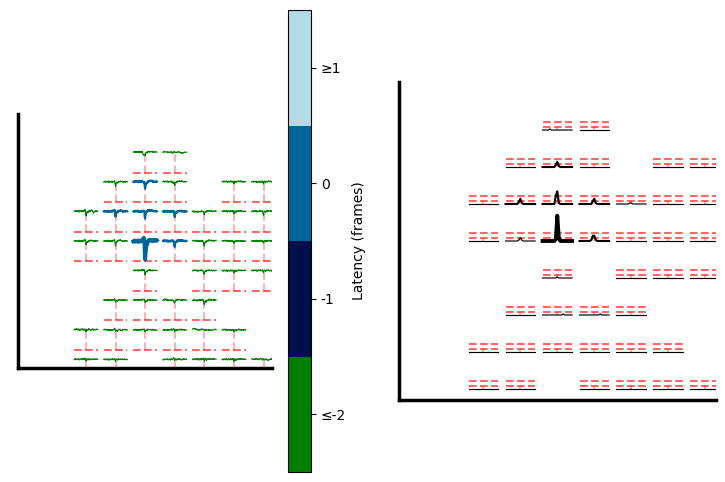


Starting on sequence 13 ...


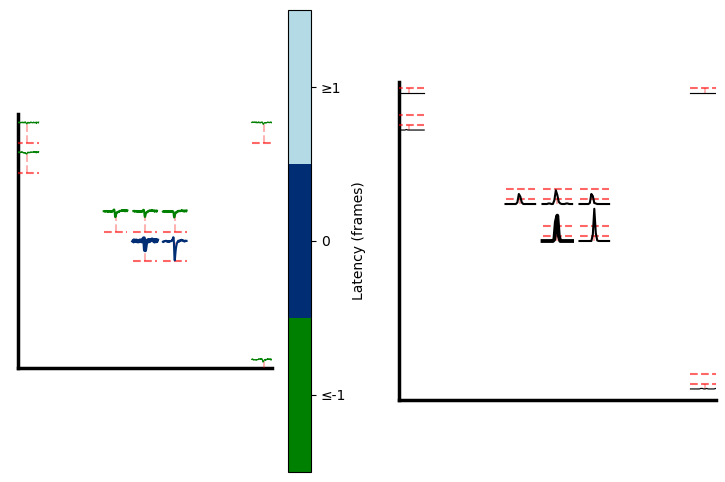


Starting on sequence 17 ...


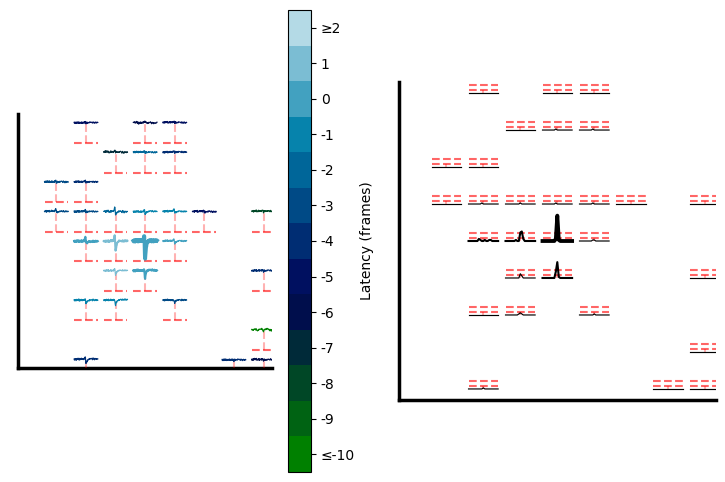

In [20]:
for idx in SEQ_IND:
    print(f"\nStarting on sequence {idx} ...")
    seq_save_root = SEQ_SAVE_ROOT / str(idx)
    seq_save_root.mkdir(exist_ok=True, parents=True)
    
    seq = trained_sequences[idx]
    
    # Plot colorbar
    amp_kwargs, prob_kwargs = F.plot_elec_probs(seq, debug=False)
    plt.savefig(seq_save_root / f"colorbar.{FORMAT}", format=FORMAT)
    plt.show()
    
    # Plot footprint
    F.plot_elec_probs(seq, show_colorbar=False, debug=False, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.savefig(seq_save_root / f"prerecording_footprint.{FORMAT}", format=FORMAT)
    plt.close()
    # plt.show()
    # break

## Run on other recordings
Need to run section "Globals setup" with pre-recording first

In [11]:
ROOT_PATH = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240318/cell2")

In [12]:
# DATE = "240303"
# INTER_DATE = DATE #"240219"  # For when using inter of different day
# SEQUENCES = utils.pickle_load(f"/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/{DATE}/trained_sequences.pickle")
SEQUENCES = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")

# for cluster in SEQUENCES:  # In case changed elec thresholds after forming
#     cluster.min_loose_detections = max(F.MIN_LOOSE_DETECTIONS_N, F.MIN_LOOSE_DETECTIONS_R_SPIKES * len(cluster.loose_elecs))

# 5, 2, 1
# RECORDING_PATHS = np.array(PATCH_PATHS)[1:]  # rec_name for RECORDING_PATHS[i] is RECORDING_PATHS[i].name.split(".")[0]
RECORDING_PATHS = [file for file in Path(PATCH_ROOT).iterdir() if str(file).strip().endswith(".h5") and file != PATCH_PATHS[0]]
# RECORDING_PATHS = ["/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cell3.raw.h5"]
# RECORDING_PATHS = ["/data/MEAprojects/primary_mouse/patch_ground_truth/181115/1916/MEA_rec_patch_cell3.raw.h5 "]
print("\n".join([str(path) for path in RECORDING_PATHS]))

# intermediate data will be stored in folder INTER_ROOT_PATH  / RECORDING_PATHS[i]
# spike times will be stored at SPIKE_TIMES_ROOT_PATH / RECORDING_PATHS[i].npy

# INTER_ROOT_PATH = Path(f"/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/{INTER_DATE}/inter")  
# SPIKE_TIMES_ROOT_PATH = Path(f"/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/{DATE}/all_spike_trains")  
INTER_ROOT_PATH = ROOT_PATH / "inter"
SPIKE_TIMES_ROOT_PATH = ROOT_PATH / "all_spike_trains"

DELETE_INTER = False  # whether to delete intermediate data


/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cell3.raw.h5
/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cell7.raw.h5


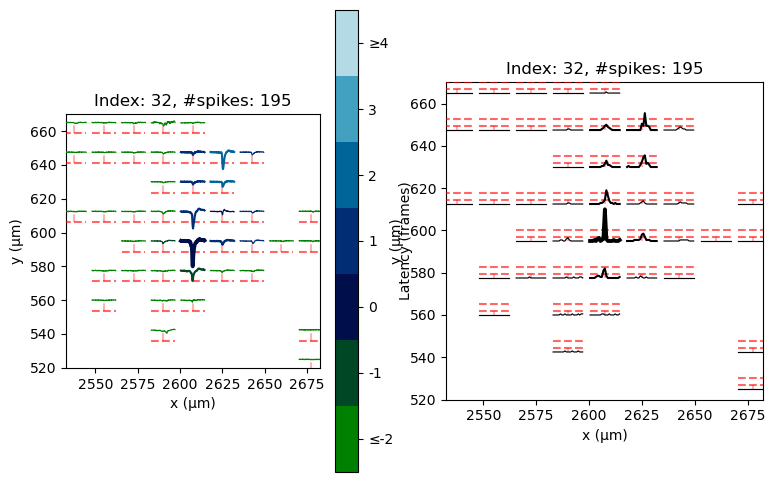

In [18]:
F.plot_elec_probs(SEQUENCES[32])
plt.show()

In [13]:
RECORDING_PATHS = ["/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cell3.raw.h5"]

In [ ]:
for rec_path in RECORDING_PATHS:    
    # Setup paths
    rec_path = Path(rec_path)
    rec_name = rec_path.name.split(".")[0]
    
    print(f"\nStarting on {rec_name}")
    
    spike_times_path = SPIKE_TIMES_ROOT_PATH / f"{rec_name}.npy"
    spike_times_path.parent.mkdir(exist_ok=True, parents=True)
    
    inter_path = INTER_ROOT_PATH / rec_name
    inter_path.mkdir(exist_ok=True, parents=True)
    
    # # If model outputs are already saved
    # model_root = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/dl_model/230101/cell7")
    # scaled_traces_path = model_root / "scaled_traces.npy"
    # model_traces_path = model_root / "model_traces.npy"
    # model_outputs_path = model_root / "model_outputs.npy"
    
    # Create model data
    scaled_traces_path = inter_path / "scaled_traces.npy"
    model_traces_path = inter_path / "model_traces.npy"
    model_outputs_path = inter_path / "model_outputs.npy"
    # F.save_traces_mea_old(rec_path, scaled_traces_path, samp_freq=SAMP_FREQ)
    # F.run_dl_model(MODEL_PATH, scaled_traces_path, model_traces_path, model_outputs_path)
    F.TRACES = np.load(model_traces_path, mmap_mode="r")
    F.OUTPUTS = np.load(model_outputs_path, mmap_mode="r")

    # print("Assigning spikes ...")
    # all_spike_trains = F.assign_spikes_torch(SEQUENCES, time_frame_ms=None, return_spikes=True)
    # torch.cuda.empty_cache()
    # np.save(spike_times_path, np.array(all_spike_trains, dtype=object))
    
    # Measure speed of assigning spikes
    speed_path = ROOT_PATH / f"online_sorting_times/{rec_name}"
    speed_path.mkdir(exist_ok=True, parents=True)
    F.MODEL_PATH = MODEL_PATH
    F.SCALED_TRACES_PATH = SCALED_TRACES_PATH
    F.INFERENCE_SCALING_NUMERATOR = None  # 240328 causes divide by zero error when using it. Not sure why
    sorting_computation_times, sorting_delays = F.measure_speed_assign_spikes_torch(SEQUENCES, time_frame_ms=None) 
    F.INFERENCE_SCALING_NUMERATOR = INFERENCE_SCALING_NUMERATOR
    torch.cuda.empty_cache()
    plt.hist(sorting_computation_times, bins=30) 
    plt.show()
    print(np.mean(sorting_computation_times))
    plt.hist(sorting_delays, bins=30) 
    plt.show()
    print(np.mean(sorting_delays))
    # np.save(speed_path / "sorting_computation_times.npy", sorting_computation_times)
    # np.save(speed_path / "sorting_delays.npy", sorting_delays)
    
    if DELETE_INTER:
        shutil.rmtree(inter_path)

In [17]:
# Load RT-Sort on patch MEA recording
rec_path="/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cell3.raw.h5"
##
rec_path= Path(rec_path)
rec_name = rec_path.name.split(".")[0]
spike_times_path = SPIKE_TIMES_ROOT_PATH / f"{rec_name}.npy"    
inter_path = INTER_ROOT_PATH / rec_name
scaled_traces_path = inter_path / "scaled_traces.npy"
model_traces_path = inter_path / "model_traces.npy"
model_outputs_path = inter_path / "model_outputs.npy"
F.TRACES = np.load(model_traces_path, mmap_mode="r")
F.OUTPUTS = np.load(model_outputs_path, mmap_mode="r")
all_spike_trains = np.load(spike_times_path, allow_pickle=True)

## Compare to patch

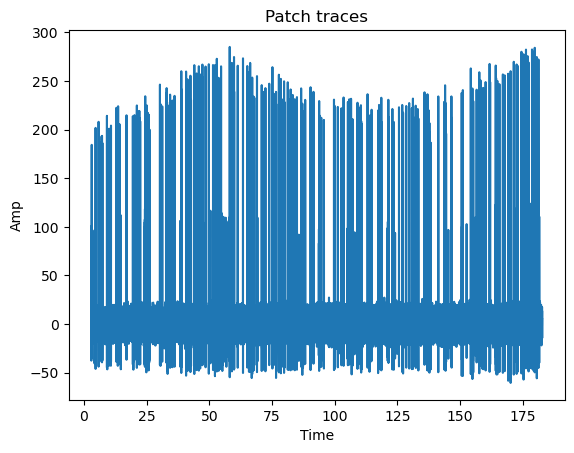

In [19]:
# Load patch
# PATCH_PATH = PATCH_ROOT / f"patch_{CELL}.mat"
PATCH_PATH = "/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_cell3.mat"

# MEA 2602 cell 7
# AMP_THRESH=100  # Patch trace must cross this to be detected as spike (mV)
# Mea 2602 cell 3
AMP_THRESH = 150

delta_time=round(3*SAMP_FREQ)  # Max offset to center spike on MEA data max-amp (in frames)
##
# Load .mat
from scipy.io import loadmat
mat = loadmat(PATCH_PATH)
times = mat['Xt_patch_all'].flatten()
amps = mat['Ydata_patch_all'].flatten()

# mask = times < 150
# amps = amps[mask]
# times = times[mask]

# Plot patch recording
plt.plot(times, amps)
plt.title("Patch traces")
plt.ylabel("Amp")
plt.xlabel("Time")
plt.show()

# Extract patch times from .mat
window = amps
main = amps[1:-1]
greater_than_left = main > window[:-2]
greater_than_right = main > window[2:]
peaks = greater_than_left & greater_than_right
crosses = main >= AMP_THRESH
patch_times = times[1:-1][crosses & peaks] * 1000 # to ms

unit = Unit(0, patch_times, -1, None)
waveforms = F.extract_waveforms(unit)
template = np.mean(waveforms, axis=0)
chan = np.argmax(np.max(np.abs(template), axis=1))
# Correct patch_times
corrected_times = []
for time in patch_times:
    frame = round(time * SAMP_FREQ)
    if frame >= F.TRACES.shape[1]-delta_time:
        continue
    window = F.TRACES[chan, max(0, frame-delta_time):frame+delta_time+1]
    peak = np.argmin(window)
    frame = frame-delta_time + peak
    time = frame / SAMP_FREQ
    corrected_times.append(time)
patch_cluster = F.CocCluster(chan, [chan], corrected_times)
patch_cluster.idx = 0
# F.plot_elec_probs(patch_cluster)
# plt.show()

In [20]:
# Find which RT seq (if any) corresponds to patch
for seq in F.get_nearby_clusters(SEQUENCES, *ELEC_LOCS[patch_cluster.root_elec], 50):
    print(seq.idx)
    # F.plot_elec_probs(seq)
    # plt.show()

41


In [19]:
# # Rerun RT
# all_spike_trains = F.assign_spikes_torch(SEQUENCES, return_spikes=True)

In [21]:
# SEQ_IDX = 32  # cell 7
SEQ_IDX = 41  # cell 3
cluster = SEQUENCES[SEQ_IDX]

# predicted_times = cluster.spike_train  # Offline RT-Sort
predicted_times = all_spike_trains[SEQ_IDX]  # Online RT-Sort

##
# If no break in patch recording
predicted_times = predicted_times[(predicted_times >= corrected_times[0] - 0.4) & (predicted_times <= corrected_times[-1] + 0.4)]

# # If break in patch recording (ex: MEA 2602 cell 7)
# last_spike_before_break = 63137.1  # MEA 2602 cell 7
# first_spike_after_break = 124079.5  # MEA 2602 cell 7
# predicted_times = predicted_times[
#     ((predicted_times >= corrected_times[0] - 0.4) & (predicted_times <= last_spike_before_break + 0.4)) \
#         | ((predicted_times >= first_spike_after_break - 0.4) & (predicted_times <= corrected_times[-1] + 0.4))
#     ]

##
predicted_cluster = deepcopy(cluster)
predicted_cluster._spike_train = predicted_times

# # Plot predicted cluster
# F.setup_cluster(predicted_cluster)
# F.plot_elec_probs(predicted_cluster)
# plt.suptitle("All RT-Sort's spikes")
# plt.show()

In [22]:
from src.comparison import Comparison
matching, predicted_only, patch_only = Comparison.get_matching_events(predicted_cluster.spike_train, patch_cluster.spike_train, delta=3)
root_elec = predicted_cluster.root_elec
split_elecs = predicted_cluster.split_elecs
matching = F.CocCluster(root_elec, split_elecs, matching)
predicted_only = F.CocCluster(root_elec, split_elecs, predicted_only)
patch_only = F.CocCluster(root_elec, split_elecs, patch_only)
# F.setup_coc_clusters((matching, predicted_only, patch_only))
# F.setup_coc_clusters((matching, patch_only))

print(f"#Matches: {len(matching.spike_train)}")
print(f"#RT-Sort only: {len(predicted_only.spike_train)}")
print(f"#Patch only: {len(patch_only.spike_train)}")
# 0.5ms and np.inf for merging and 50 loose elec seq noise, makes sense dince different samp freq and inserted into dense region so window needs to be more selective

# For manuscript:
print(f"\n#Patch: {len(patch_cluster.spike_train)}")
print(f"#False negatives: {len(patch_only.spike_train)}")
print(f"#False positives: {len(predicted_only.spike_train)}")

#Matches: 202
#RT-Sort only: 0
#Patch only: 8

#Patch: 210
#False negatives: 8
#False positives: 0


In [ ]:
for idx, spike in enumerate(patch_only.spike_train):
    print(spike)
    F.plot_seq_spike_overlap(cluster, spike, idx)
    plt.show()
    
    frame = F.rec_ms_to_output_frame(spike)
    window = F.OUTPUTS[:, frame]
    # print(np.sum(window >= F.LOOSE_THRESH_LOGIT))

In [ ]:
# Plot individual patch only spikes
num_spikes=4
np.random.seed(1)

all_predictions = []
all_predictions_seq_ind = []
for idx, spike_train in enumerate(all_spike_trains):
    all_predictions.extend(spike_train)
    all_predictions_seq_ind += [idx] * len(spike_train)
for idx in np.random.choice(patch_only.spike_train.size, num_spikes, replace=False):
    spike = patch_only.spike_train[idx]
    print("-"*100)
    print(spike)
    F.plot_seq_spike_overlap(predicted_cluster, spike, idx=idx)
    plt.show()
    spike_detected = np.abs(all_predictions - spike) <= 0.4
    if np.any(spike_detected):
        for idx in np.flatnonzero(spike_detected):
            seq = SEQUENCES[all_predictions_seq_ind[idx]]
            F.plot_spikes(all_spike_trains[all_predictions_seq_ind[idx]], seq.root_elec, idx=seq.idx)
            plt.show()    

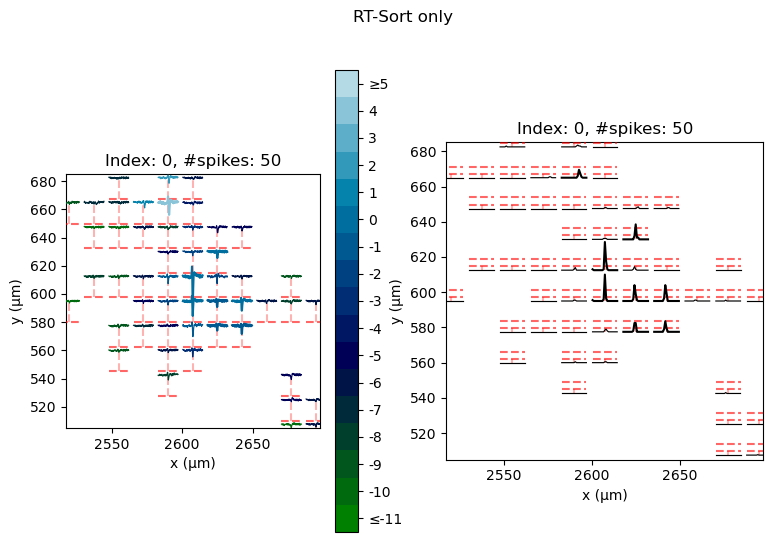

In [69]:
# F.plot_elec_probs(matching)
# plt.suptitle("Matching")
# plt.show()

F.plot_elec_probs(predicted_only)
plt.suptitle("RT-Sort only")
plt.show()

# F.plot_elec_probs(patch_only)
# plt.suptitle("Patch only")
# plt.show()

# last_patch_spike = np.max(patch_cluster.spike_train)
# print(f"Last patch spike: {last_patch_spike/1000:.2f}s")
# within_patch_spikes = predicted_only.spike_train[predicted_only.spike_train <= last_patch_spike]
# F.plot_spikes(within_patch_spikes, root_elec)
# plt.suptitle("RT-Sort only within patch time")
# plt.show()

In [ ]:
# Plot amplitude distributions of pre-recording and patch only
xlim=(0, 28)
bins=30

plt.title("Sequence in pre-recording")
plt.hist(SEQUENCES[SEQ_IDX].every_amp_median[root_elec], range=xlim, bins=bins)
plt.xlabel("Standardized amp")
plt.ylabel("#spikes")
plt.show()

plt.title("Patch-only spikes")
plt.hist(patch_only.every_amp_median[root_elec], range=xlim, bins=bins)
plt.xlabel("Standardized amp")
plt.ylabel("#spikes")
plt.show()

In [ ]:
# Show ISI violations
F.plot_isi_viols(patch_cluster, ms_before_after=3)

#### Plotting for manuscript

In [27]:
# Cell 7
# SEQ_IDX = 32 

# Cell 3
SEQ_IDX = 41 
SEQ_SAVE_ROOT = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240318/cell2/cell3_figures")
FORMAT = "svg"

ALL_SPIKE_TRAINS_PATH = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240318/cell2/all_spike_trains/patch_rec_cell3.npy")
INTER_PATH = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240318/cell2/inter/patch_rec_cell3")
##
SEQ_SAVE_ROOT.mkdir(parents=True, exist_ok=True)
SEQ = SEQUENCES[SEQ_IDX]

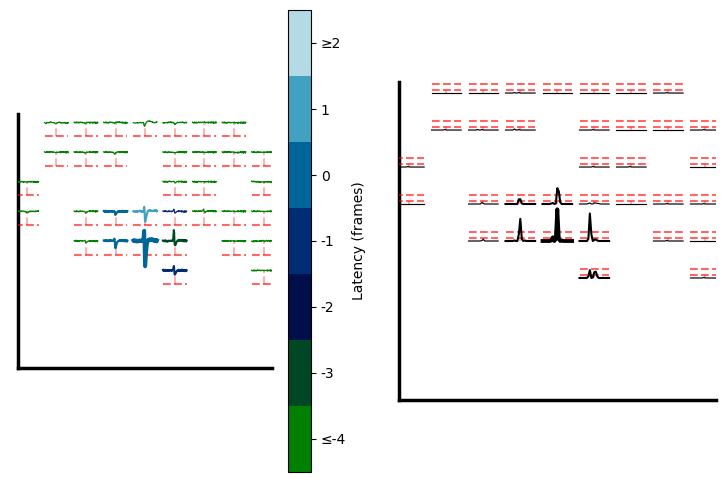

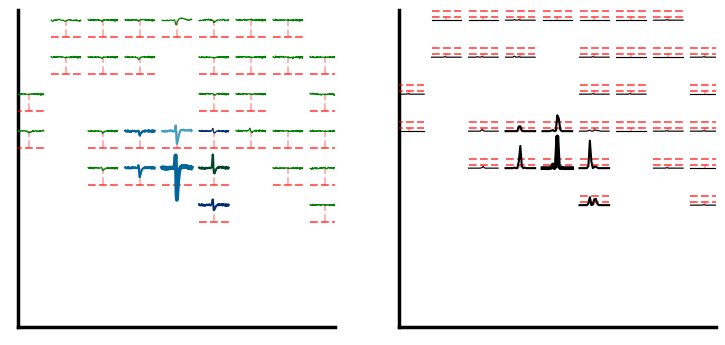

100%|██████████| 208/208 [02:24<00:00,  1.44it/s]


In [33]:
# Plot sequence footprint and all spikes for manuscript
## 
SEQ_SAVE_ROOT.mkdir(parents=True, exist_ok=True)

F.TRACES = np.load(MODEL_TRACES_PATH, mmap_mode="r")
F.OUTPUTS = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")

# Plot colorbar
amp_kwargs, prob_kwargs = F.plot_elec_probs(SEQ, debug=False)
plt.savefig(SEQ_SAVE_ROOT / f"colorbar.{FORMAT}", format=FORMAT)
plt.show()

# Plot footprint
F.plot_elec_probs(SEQ, show_colorbar=False, debug=False, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.savefig(SEQ_SAVE_ROOT / f"prerecording_footprint.{FORMAT}", format=FORMAT)
plt.show()

# Plot individual spikes
spikes_save_root = SEQ_SAVE_ROOT / "spikes"
spikes_save_root.mkdir(parents=True, exist_ok=True)

F.TRACES = np.load(INTER_PATH / "model_traces.npy", mmap_mode="r")
F.OUTPUTS = np.load(INTER_PATH / "model_outputs.npy", mmap_mode="r")
spike_train = np.load(ALL_SPIKE_TRAINS_PATH, allow_pickle=True)[SEQ_IDX]
for idx, spike in enumerate(tqdm(spike_train)):
    F.plot_spikes([spike], SEQ.root_elec, show_colorbar=False, debug=False, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.savefig(spikes_save_root / f"{idx}.{FORMAT}", format=FORMAT)
    plt.close()
    # plt.show()
    # break

In [76]:
# Save raw MEA traces in uV
# SAVED_TRACES_PATH refers to scaled_traces.npy, but I don't want to call it SCALED_TRACES_PATH in case calling it that causes problems elsewhere in this notebook
SAVED_TRACES_PATH = "/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240318/cell2/inter/patch_rec_cell7/scaled_traces.npy"  
##
scaled_traces = np.load(SAVED_TRACES_PATH, mmap_mode="r")[SEQ.root_elec, :]
np.save(SEQ_SAVE_ROOT / "raw_mea_traces_uV.npy", scaled_traces)

In [84]:
# Save DL detections
# SAVED_MODEL_OUTPUTS_PATH refers to model_outputs.npy, but I don't want to call it MODEL_OUTPUTS_PATH in case calling it that causes problems elsewhere in this notebook
SAVED_MODEL_OUTPUTS_PATH = "/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240318/cell2/inter/patch_rec_cell7/model_outputs.npy"  
##
model_outputs = F.sigmoid(np.load(SAVED_MODEL_OUTPUTS_PATH, mmap_mode="r")[SEQ.root_elec, :]) * 100
np.save(SEQ_SAVE_ROOT / "model_detection_scores.npy", model_outputs)

## Compare to kilosort
For development and testing

### Setup

In [35]:
%autoreload 2
from src.comparison import Comparison
from src.sorters.base import SpikeSorter
from src.sorters.kilosort import get_experts_kilosort

In [36]:
kilosort = get_experts_kilosort(testing_ms=TESTING_MS)

# Create all_ks_units with self.templates and self.chan set --> Don't run this if already ran before
all_ks_units = []

def job(idx):
    unit = Unit(idx, all_ks_spike_times[idx], -1, RECORDING)
    templates = unit.get_templates()
    unit.templates = templates
    unit.recording = None
    unit.chan = np.argmin(np.min(templates, axis=1))
    unit.root_elecs = [unit.chan]
    return unit

all_ks_spike_times = kilosort.get_spike_times()
with Pool(processes=20) as pool:
    tasks = range(len(all_ks_spike_times))
    for unit in tqdm(pool.imap(job, tasks), total=len(tasks)):
        unit.recording = RECORDING
        all_ks_units.append(unit)
        
chan_to_ks_units = {}
for unit in all_ks_units:
    if unit.chan not in chan_to_ks_units:
        chan_to_ks_units[unit.chan] = [unit]
    else:
        chan_to_ks_units[unit.chan].append(unit)

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


/data/MEAprojects/PropSignal/src/sorters/kilosort.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array([spikes1[idx] for idx in range(len(comp.match12)) if comp.match12[idx] != -1])
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kw

Recording does not have scaled traces. Setting gain to 0.195


100%|██████████| 226/226 [05:34<00:00,  1.48s/it]


In [ ]:
# chan_to_prop_units = {}
# for unit in final_sequences:
#     for chan in unit.root_elecs:
#         if chan not in chan_to_prop_units:
#             chan_to_prop_units[chan] = [unit]
#         else:
#             chan_to_prop_units[chan].append(unit)

### Start comparing

In [38]:
Comparison.count_all_overlaps(prop_signal.get_spike_times(), kilosort.get_spike_times())

0.7744873141843379
0.6121951079335157


Num RT-Sort: 226
Num Experts Kilosort: 226

Spikeinterface formula
19/226 matches
19/226 max matches

For RT-Sort:
Num max matches: 19
Num unique max matches: 19

For Experts Kilosort:
Num max matches: 21
Num unique max matches: 19


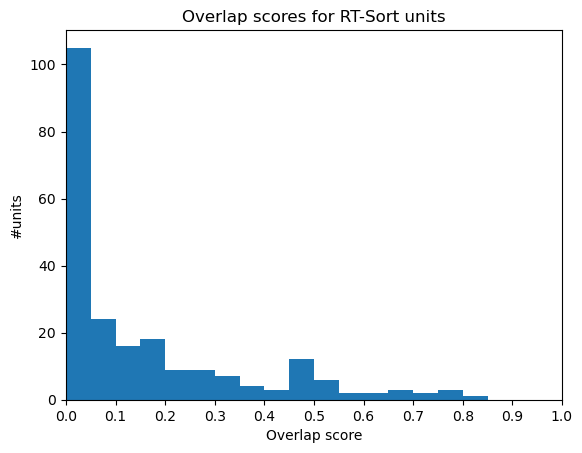

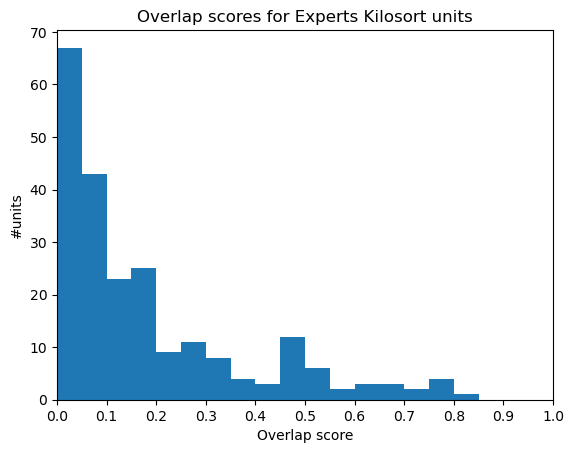

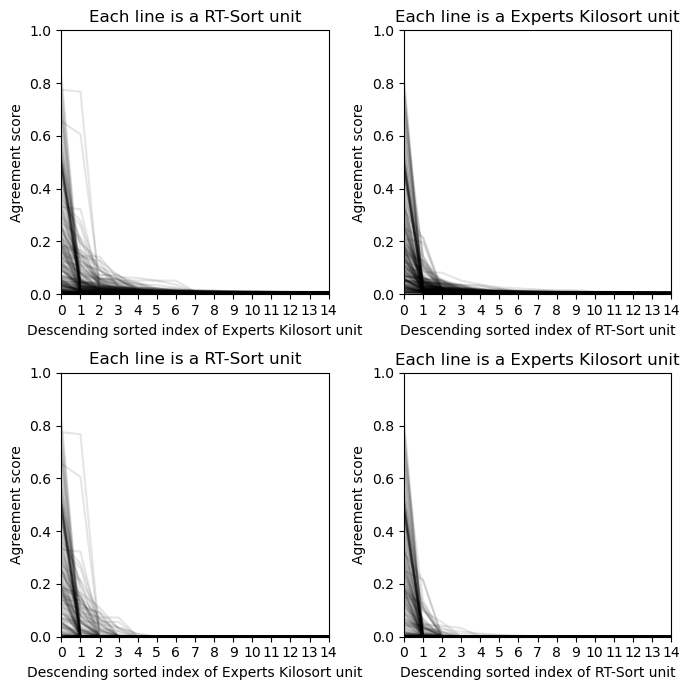

Num RT-Sort: 226
Num Experts Kilosort: 226

#matches/#rt_sort
54/226 matches
64/226 max matches

For RT-Sort:
Num max matches: 64
Num unique max matches: 54

For Experts Kilosort:
Num max matches: 57
Num unique max matches: 54


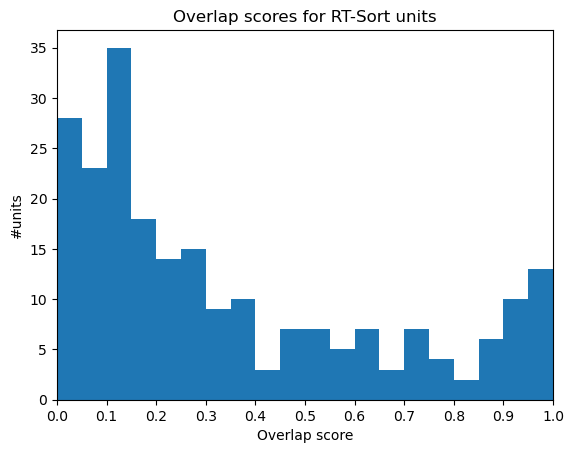

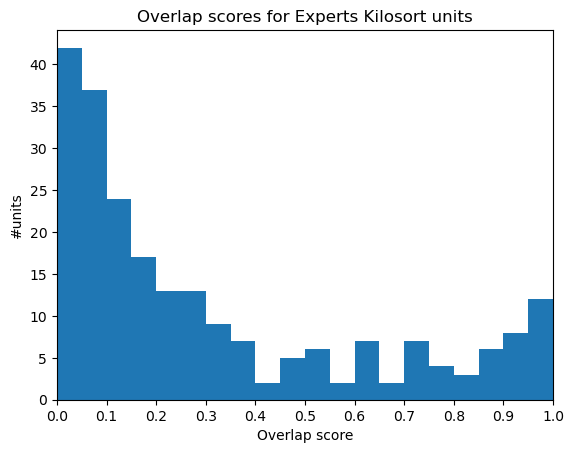

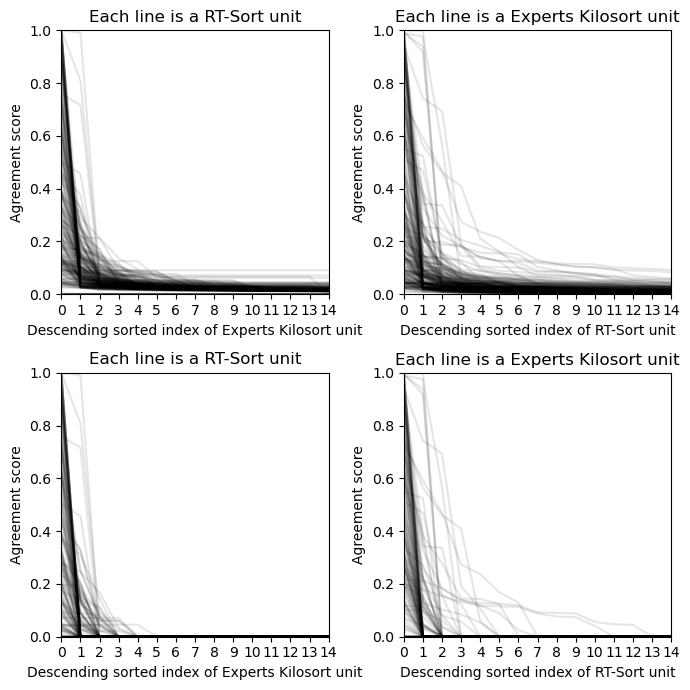

Num RT-Sort: 226
Num Experts Kilosort: 226

#matches/#kilosort
45/226 matches
45/226 max matches

For RT-Sort:
Num max matches: 45
Num unique max matches: 45

For Experts Kilosort:
Num max matches: 55
Num unique max matches: 45


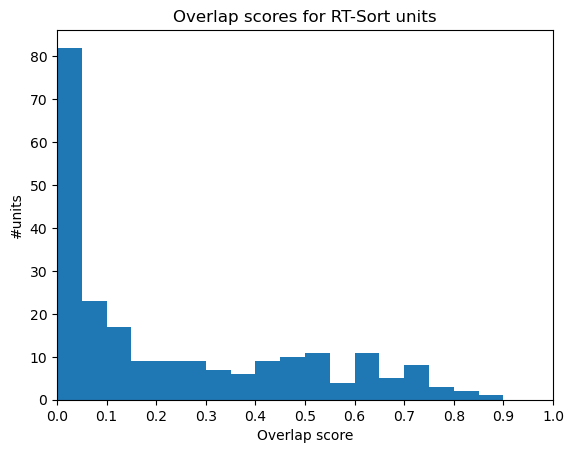

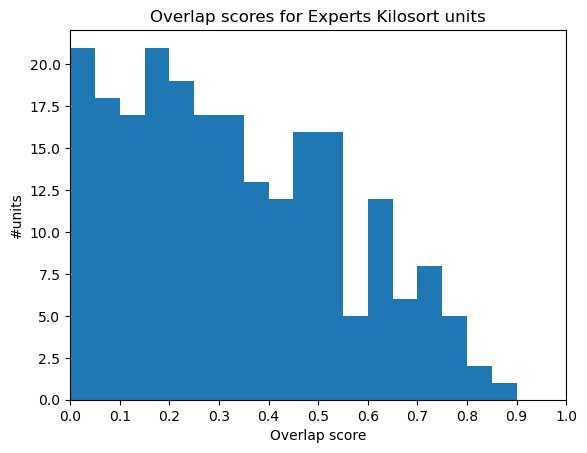

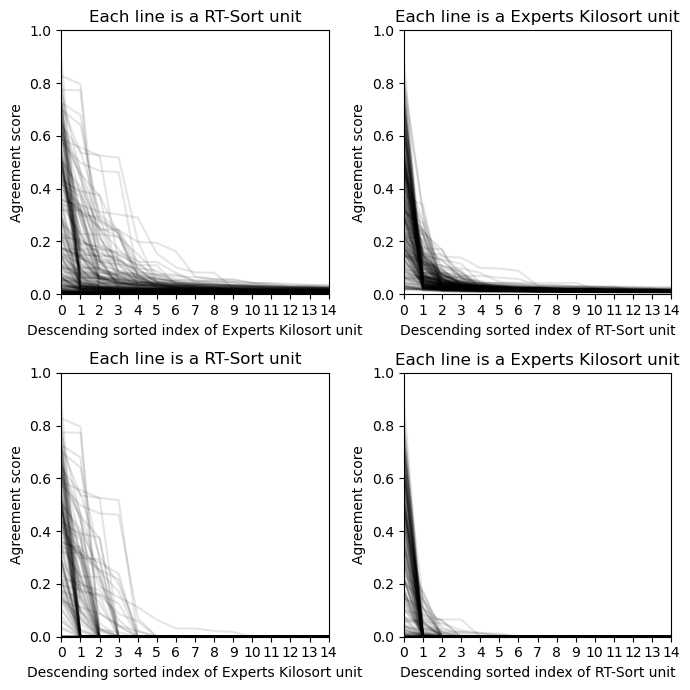

In [39]:
comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5, delta_time=0.4)
comp_1_5.summary()
comp_1_5.plot_line_comps()

comp_1 = Comparison(prop_signal, kilosort, score_formula=1, delta_time=0.4)
comp_1.summary()
comp_1.plot_line_comps()

comp_2 = Comparison(prop_signal, kilosort, score_formula=2, delta_time=0.4)
comp_2.summary()
comp_2.plot_line_comps()

In [ ]:
CHAN = 17

prop_units = chan_to_prop_units[CHAN]
ks_units = chan_to_ks_units[CHAN]
##
print(len(prop_units))
print(len(ks_units))

3
4


In [ ]:
for unit in prop_units:   
    amp_kwargs, prob_kwargs = F.plot_elec_probs(unit)#, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

In [ ]:
for unit in ks_units:   
    amp_kwargs, prob_kwargs = F.plot_elec_probs(unit)#, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

In [ ]:
all_prop_spikes = set()
for unit in final_sequences:
    all_prop_spikes.update(unit._spike_train)
all_prop_spikes = np.sort(list(all_prop_spikes))

In [ ]:
prop_unit = sequence = prop_units[2]
ks_unit = ks_units[2]

amp_kwargs, prob_kwargs = F.plot_elec_probs(prop_unit)
plt.show()

F.plot_elec_probs(ks_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.show()

In [ ]:
elec_weights = F.get_elec_weights(unit_elec_probs, elec_probs, for_latencies=True)
latency_diff = np.sum(np.abs(unit_latencies - latencies) * elec_weights)

for elec, weight, unit_latency, latency in zip(elecs[1:], elec_weights, unit_latencies, latencies):
    print(f"{elec}: {unit_latency:.2f}, {latency:.2f}, {weight*100:.1f}%, {np.abs(unit_latency - latency)*weight*100:.1f}%")

19: 2.98, 1.00, 16.0%, 31.7%
15: 0.30, -3.00, 7.9%, 26.0%
18: 3.03, 1.00, 4.7%, 9.6%
21: 3.69, 1.00, 13.6%, 36.7%
13: 0.60, -13.00, 4.9%, 67.2%
22: 4.15, 1.00, 8.1%, 25.4%
14: 0.94, -12.00, 1.2%, 16.0%
16: 2.03, -3.00, 2.1%, 10.6%
20: 4.34, 2.00, 8.1%, 18.9%
23: 6.06, -3.00, 10.2%, 92.8%
11: 0.57, -12.00, 1.3%, 16.4%
24: 4.71, -2.00, 2.2%, 14.6%
12: 0.99, -12.00, 0.0%, 0.0%
9: 0.57, -12.00, 2.6%, 33.2%
25: 5.40, -4.00, 11.2%, 104.9%
26: 4.35, -3.00, 4.9%, 35.9%
10: 0.73, -11.00, 0.9%, 10.9%


In [ ]:
elec_weights = F.get_elec_weights(unit_elec_probs, elec_probs, for_latencies=False)
amp_median_div = (unit_amp_medians + amp_medians) / 2
amp_median_diff = np.abs((unit_amp_medians - amp_medians)) / amp_median_div
print(amp_median_diff[0])
print(amp_median_diff)
print(np.sum(amp_median_diff * elec_weights))

0.09285006
[0.09285006 0.01739845 0.42813304 0.26943627 0.29808164 1.0423726
 0.30952084 1.1683204  0.51168346 0.4498598  0.9677229  0.959181
 0.10201103 0.545433   1.1859486  1.3195163  1.0869895  0.8530344 ]
0.5253458


## Kilosort units as sequences
Test assigning spikes by treating kilosort units as sequences

In [9]:
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230")

In [10]:
%autoreload 2
from src.comparison import Comparison
from src import plot
from src.sorters.base import Unit
from src.sorters.kilosort import get_experts_kilosort

In [11]:
kilosort = get_experts_kilosort(testing_ms=TRAINING_MS, overlap_time=0.1)

Recording does not have scaled traces. Setting gain to 0.195


In [12]:
# Setup kilosort units as sequences --> need to find root elec (max-amp elec)

original_ks_sequences = []
original_ks_spike_times = kilosort.get_spike_times()
chan_to_ks_seqs = {}

def job(idx):    
    cluster = F.CocCluster(-1, -1, -1, -1)
    cluster._spike_train = original_ks_spike_times[idx]
    
    all_waveforms = F.extract_waveforms(cluster, use_filt=True)   
    templates = np.mean(all_waveforms, axis=0)
    root_elec = np.argmin(np.min(templates, axis=1))
    
    cluster.root_elec = root_elec
    cluster.root_elecs = [root_elec]
    F.setup_cluster(cluster)
    
    return cluster

with Pool(processes=20) as pool:
    tasks = range(len(original_ks_spike_times))
    for idx, cluster in tqdm(enumerate(pool.imap(job, tasks)), total=len(tasks)):
        cluster.idx = idx
        original_ks_sequences.append(cluster)
        
for seq in chan_to_ks_seqs:
    if seq.root_elec not in chan_to_ks_seqs:
        chan_to_ks_seqs[seq.root_elec] = [seq]
    else:
        chan_to_ks_seqs[seq.root_elec].append(seq)

100%|██████████| 226/226 [02:28<00:00,  1.53it/s]


In [ ]:
# viol_p = []
# for seq in original_ks_sequences:
#     spike_train = seq.spike_train
#     isis = np.diff(spike_train)
#     num_viols = np.sum(isis <= 1.5)
#     viol_p.append(num_viols / len(spike_train) * 100)
# plt.hist(viol_p, bins=60)
# plt.show()

In [13]:
# Called "all" but these are the sequences that can be detected by RT-Sort (at least 2 loose elecs)
all_ks_sequences = []
all_ks_spike_times = []

un_ks_sequences = []  # Sequences that cannot be detected by RT-Sort
for seq, times in zip(original_ks_sequences, original_ks_spike_times):
    if len(seq.loose_elecs) >= 2:
        all_ks_sequences.append(seq)
        all_ks_spike_times.append(times)
    else:
        un_ks_sequences.append(seq)
        
print(f"{len(original_ks_sequences)} kilosort units")
print(f"{len(all_ks_sequences)} detectable kilosort units (at least 2 loose elecs)")

226 kilosort units
211 detectable kilosort units (at least 2 loose elecs)


In [130]:
for seq in un_ks_sequences:
    F.plot_elec_probs(seq)
    # plt.savefig(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints_undetectable/{seq.idx}.jpg", format="jpg")
    # plt.close()

In [15]:
F.assign_spikes(all_ks_sequences, TRAINING_MS,
                interelec=True, only_max_amps=False,
                verbose=True)

100%|██████████| 3909373/3909373 [24:15<00:00, 2685.31it/s]


In [132]:
for seq in all_ks_sequences:
    if len(seq.spike_train) == 0:
        seq._spike_train = seq.formation_spike_train
        F.plot_elec_probs(seq)
        seq._spike_train = []
        plt.savefig(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints/no_spikes/{seq.idx}.jpg", format="jpg")
        plt.close()

In [16]:
utils.pickle_dump(all_ks_sequences, SAVE_ROOT / "all_ks_sequences.pickle")
prop_signal = F.clusters_to_sorter(all_ks_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, SAVE_ROOT / "ks_as_prop_signal.pickle")

In [21]:
# ks_as_prop_signal = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231219/ks_as_prop_signal.pickle")
# all_ks_sequences = []
# for unit in ks_as_prop_signal:
#     unit.root_elec = unit.chan
#     all_ks_sequences.append(unit)

In [111]:
# Naive way to check precision and recall (does not account for location of units when finding spike match)
all_prop_spikes = []
for seq in all_ks_sequences:
    all_prop_spikes.extend(seq.spike_train)
all_prop_spikes = np.sort(all_prop_spikes)

all_ks_spikes = []
for spike_train in all_ks_spike_times:
    all_ks_spikes.extend(spike_train)
all_ks_spikes = np.sort(all_ks_spikes)

matching_prop_times, unmatched_prop_times, unmatched_ks_times = Comparison.get_matching_events(all_prop_spikes, all_ks_spikes)

# num_matches = len(matching_prop_times)
# print(f"#matches: {num_matches}")
# print(f"#matches/#rt_sort: {num_matches/(len(unmatched_prop_times) + num_matches)*100:.1f}%")
# print(f"#matches/#kilosort: {num_matches/(len(unmatched_ks_times) + num_matches)*100:.1f}%")

tp = len(matching_prop_times)
fp = len(unmatched_prop_times)
fn = len(unmatched_ks_times)
print(f"For RT-Sort, relative to kilosort")
print(f"Precision: {tp / (tp+fp) *100:.1f}%")
print(f"Recall: {tp / (tp + fn) *100:.1f}%")

For RT-Sort, relative to kilosort
Precision: 83.9%
Recall: 49.5%


In [110]:
# Correct way to check precision and recall

# Need to format as Unit objects for F.select_prop_spikes_within_kilosort_spikes
all_ks_units = []  # Contains spikes detected by kilosort
all_prop_units = []  # Contains spikes detected with rt_sort method
for idx, (ks_spike_times, ks_sequence) in enumerate(zip(all_ks_spike_times, all_ks_sequences)):
    all_ks_units.append(Unit(idx, ks_spike_times, ks_sequence.root_elec, None))
    all_prop_units.append(Unit(idx, ks_sequence.spike_train, ks_sequence.root_elec, None))

# Spikes detected by 1) prop and kilosort 2) prop but not kilosort
prop_and_ks_units, prop_only_units, ks_only_units = F.select_prop_spikes_within_kilosort_spikes(all_prop_units, all_ks_units, return_ks_only_units=True)

# Find precision and recall (sanity check)
tp = sum(len(unit.spike_train) for unit in prop_and_ks_units)
fp = sum(len(unit.spike_train) for unit in prop_only_units)
fn = sum(len(unit.spike_train) for unit in ks_only_units)
print(f"For RT-Sort, relative to kilosort")
print(f"Precision: {tp / (tp+fp) *100:.1f}%")
print(f"Recall: {tp / (tp + fn) *100:.1f}%")

For RT-Sort, relative to kilosort
Precision: 73.8%
Recall: 43.5%


In [ ]:
for ks_unit, prop_unit in zip(all_ks_units, all_prop_units):
    # print("-"*50)
    if len(prop_unit.spike_train) > 0:
        continue
    amp_kwargs, prob_kwargs = F.plot_elec_probs(ks_unit)
    plt.show()
    # F.plot_elec_probs(prop_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    # plt.show()
    

In [106]:
# Get spike data for kilosort only spikes
F.set_ks_only_spike_match_scores(ks_only_units, all_ks_sequences)

  0%|          | 0/211 [00:00<?, ?it/s]

100%|██████████| 211/211 [13:20<00:00,  3.80s/it]

Undetectable sequences: []


In [ ]:
# Fix unit.time_to_spike_match if changes are needed
# for unit in ks_only_units:
#     for time in unit.time_to_spike_match:
#         data = unit.time_to_spike_match[time]
#         if data[1] < 2:
#             unit.time_to_spike_match[time] = [data[0], data[1], data[2], np.nan, np.nan, np.nan, np.nan]

Num. inner loose electrodes


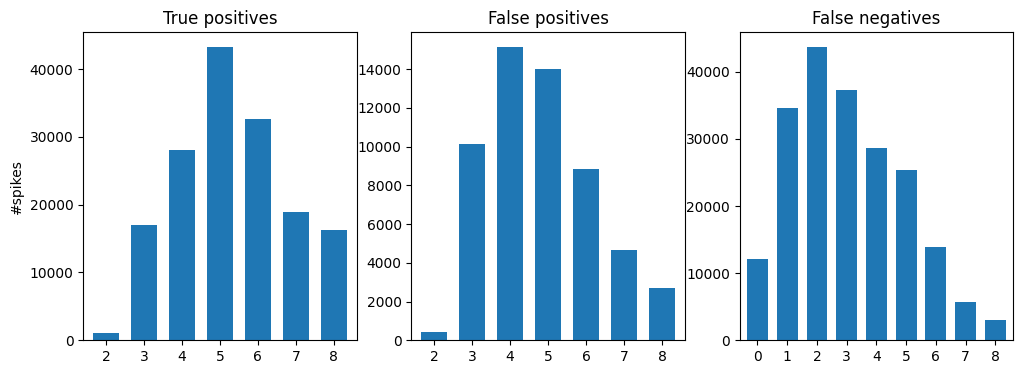

In [107]:
"""
For each metric, plot histograms for all:
    1. True positives (prop_and_ks_units)
    2. False positives (prop_only_units)
    3. False negatives (ks_only_units)
    
metrics: (elec, num_inner_loose_elecs, num_loose_elecs, fraction_loose_elecs, latency_diff, amp_median_diff, score)
"""
metric_idx = 1  # metric index in time_to_spike_match[time]
print("Num. inner loose electrodes")  

fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
              
plot.bar(true_positives, ax=a0)
plot.bar(false_positives, ax=a1)
plot.bar(false_negatives, ax=a2)

a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Num. loose elecs


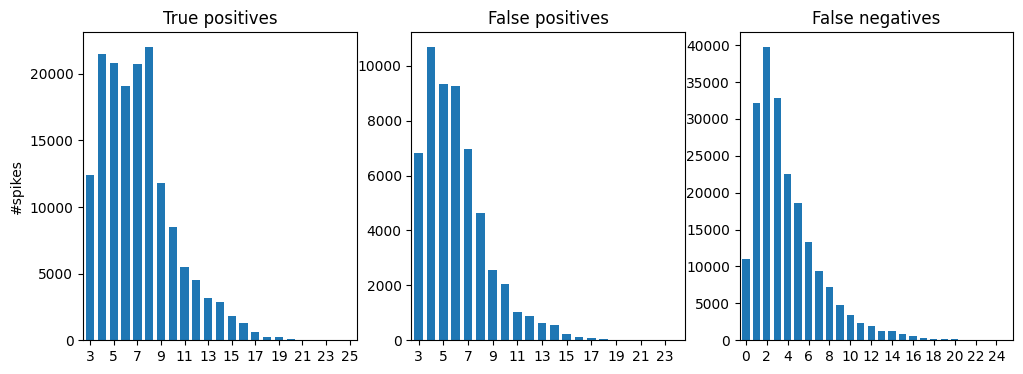

In [108]:
metric_idx = 2 
print(f"Num. loose elecs")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
plot.bar(true_positives, ax=a0)
plot.bar(false_positives, ax=a1)
plot.bar(false_negatives, ax=a2)

for ax in (a0, a1, a2):
    ax.set_xticks(ax.get_xticks()[::2])
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Percent loose elecs


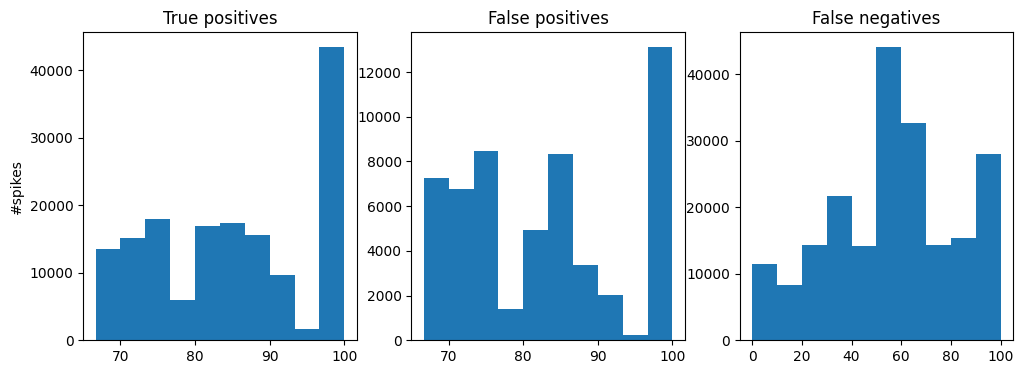

In [112]:
metric_idx = 3
print(f"Percent loose elecs")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 10}
plot.hist(np.array(true_positives)*100, axis=a0, **kwargs)
plot.hist(np.array(false_positives)*100, axis=a1, **kwargs)
plot.hist(np.array(false_negatives)*100, axis=a2, **kwargs)

# for ax in (a0, a1):
#     ax.set_xticks(ax.get_xticks()[::2])
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Latency difference


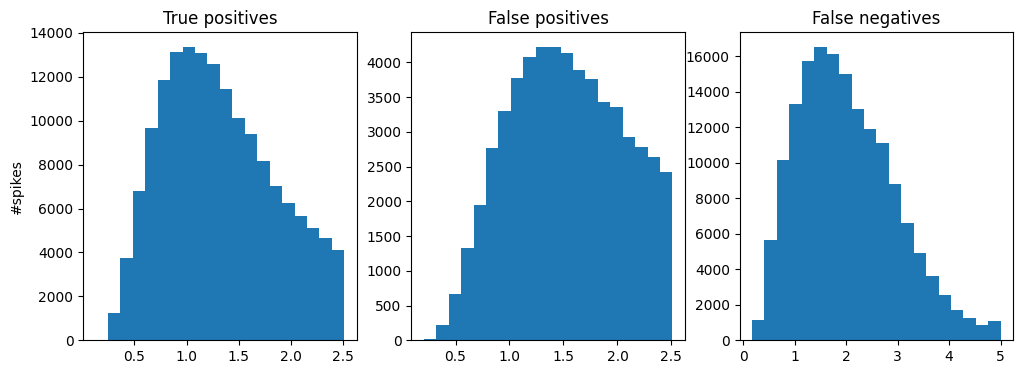

In [113]:
metric_idx = 4
print(f"Latency difference")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 20}
plot.hist(true_positives, axis=a0, **kwargs)
plot.hist(false_positives, axis=a1, **kwargs)
plot.hist(false_negatives, axis=a2, **kwargs)
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Amplitude difference


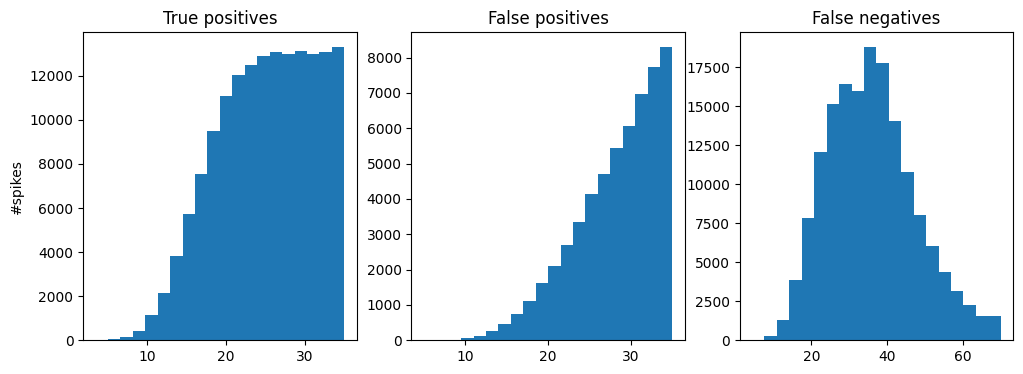

In [114]:
metric_idx = 5
print(f"Amplitude difference")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 20}
plot.hist(np.array(true_positives)*100, axis=a0, **kwargs)
plot.hist(np.array(false_positives)*100, axis=a1, **kwargs)
plot.hist(np.array(false_negatives)*100, axis=a2, **kwargs)
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

#### Scatter plots
metrics: (elec, num_inner_loose_elecs, num_loose_elecs, fraction_loose_elecs, latency_diff, amp_median_diff, score)

In [115]:
all_true_positives, all_false_positives, all_false_negatives = F.get_spike_metrics(all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)

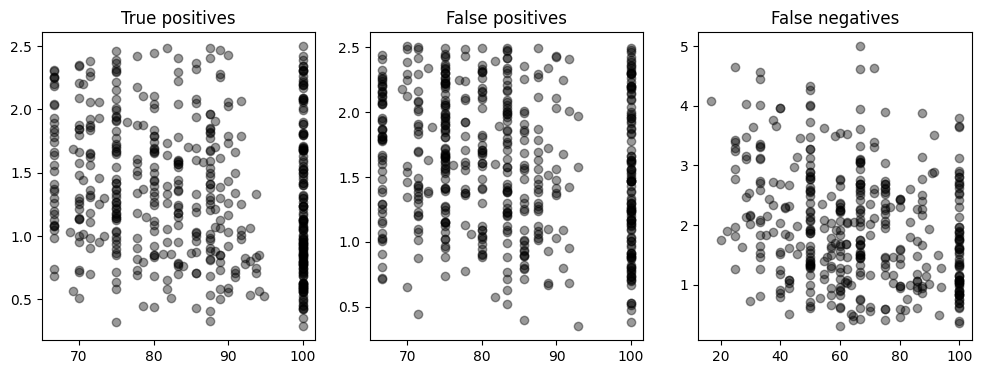

In [116]:
x_metric = 3  # fraction_loose_elecs 
y_metric = 4  # latency_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] * 100  # To make into percent
        y = metrics[y_metric]
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

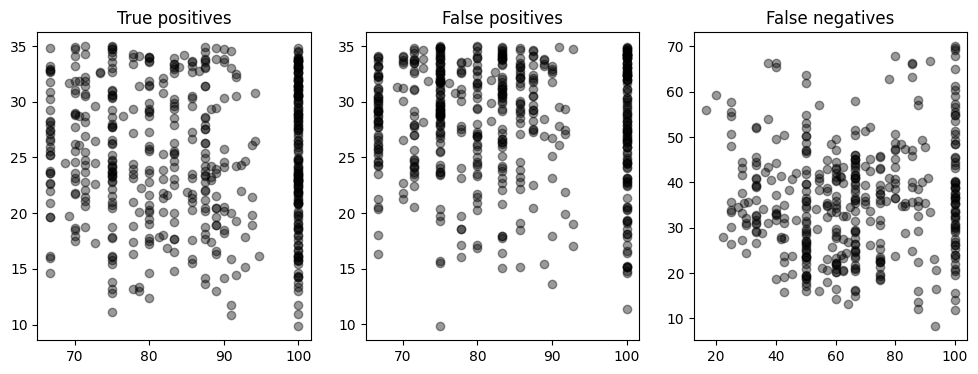

In [117]:
x_metric = 3  # fraction_loose_elecs 
y_metric = 5  # amp_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] * 100  # To make into percent
        y = metrics[y_metric] * 100  # To make into percent
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

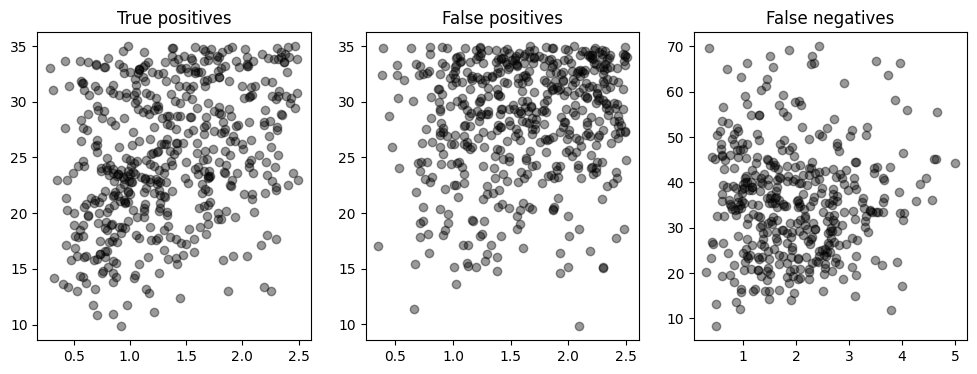

In [118]:
x_metric = 4  # latency_diff 
y_metric = 5  # amp_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] 
        y = metrics[y_metric] * 100  # To make into percent
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

#### Precision and recall after each spike assignment threshold

In [94]:
assert False, "This does not work because it does not account for the new false negatives caused by loosening thresholds"

PARAM_TESTS = (
    # (2, 3, 2/3, 2.51, 0.35),
    (-np.inf, -np.inf, -np.inf, np.inf, np.inf),
    # (-np.inf, 3, -np.inf, np.inf, np.inf),
    # (2, 3, -np.inf, np.inf, np.inf),
    # (2, 3, 2/3, np.inf, np.inf),
    # (2, 3, 2/3, 2.51, np.inf),
    # (2, 3, -np.inf, np.inf, 0.35)
    # (2, 3, 2/3, 2.51, 0.35),
    
    # (2, 3, -np.inf, 2.51, 0.35),
    # (2, 3, -np.inf, 4, 0.35), 
    # (2, 3, -np.inf, 2.51, 0.50), 
    # (2, 3, -np.inf, 4, 0.50), 
    # (2, 3, -np.inf, 5, 0.7), 
)
##
all_true_positives, all_false_positives, all_false_negatives = F.get_spike_metrics(all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
for (min_inner_loose_detections, min_loose_detections_n, min_loose_detections_r, max_latency_diff, max_amp_median_diff) in PARAM_TESTS:
    num_tp = num_fp = num_fn = 0
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_true_positives:
        if num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_tp += 1
        else:
            num_fp += 1
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_false_positives:
        if num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_fp += 1
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_false_negatives:
        if np.isnan(latency_diff):
            num_fn += 1
        elif num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_tp += 1
        else:
            num_fn += 1
    
    print(f"{min_inner_loose_detections}_{min_loose_detections_n}_{min_loose_detections_r*100:.0f}%, {max_latency_diff} frames, {max_amp_median_diff}%")
    print(f"Precision: {num_tp / (num_tp+num_fp) *100:.1f}%")
    print(f"Recall: {num_tp / (num_tp + num_fn) *100:.1f}%")
    print()
    
    # Probably because of spike splitting, precision and recall when using correct thresholds are slightly difference

-inf_-inf_-inf%, inf frames, inf%
Precision: 84.9%
Recall: 87.1%



#### Footprints

--------------------------------------------------


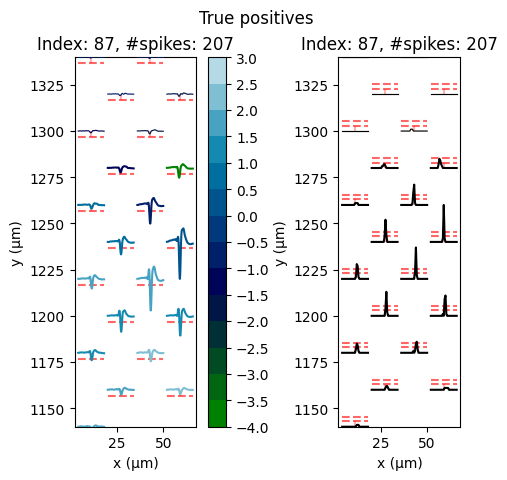

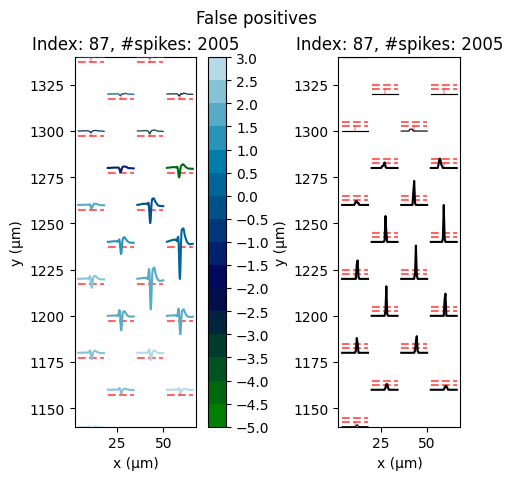

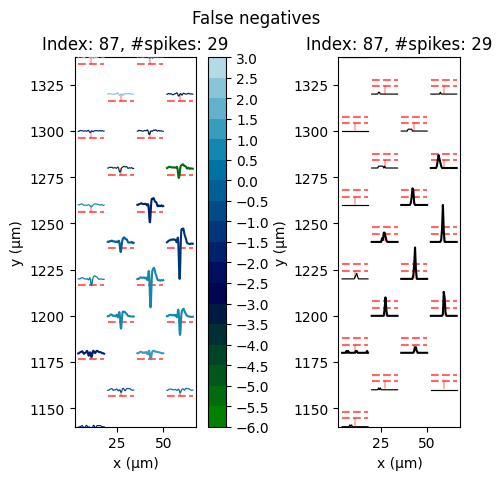

In [ ]:
num_units = 1
##
np.random.seed(231)
ind = np.random.choice(len(prop_and_ks_units), num_units)

# for prop_and_ks, prop_only, ks_only in zip(prop_and_ks_units, prop_only_units, ks_only_units):
for idx in ind:
    prop_and_ks, prop_only, ks_only = prop_and_ks_units[idx], prop_only_units[idx], ks_only_units[idx]
    print("-"*50)
    
    F.plot_elec_probs(prop_and_ks)
    plt.suptitle("True positives")
    plt.show()
    
    F.plot_elec_probs(prop_only)
    plt.suptitle("False positives")
    plt.show()
    
    F.plot_elec_probs(ks_only)
    plt.suptitle("False negatives")
    plt.show()

#### Save footprints

In [122]:
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints")

In [123]:
for prop_and_ks, prop_only, ks_only in zip(tqdm(prop_and_ks_units), prop_only_units, ks_only_units):
    # For testing
    # idx = 44
    # prop_and_ks, prop_only, ks_only = prop_and_ks_units[idx], prop_only_units[idx], ks_only_units[idx]

    save_path = SAVE_ROOT / str(prop_and_ks.idx)
    save_path.mkdir(parents=True, exist_ok=True)

    if len(prop_and_ks.spike_train) > 0:
        F.plot_elec_probs(prop_and_ks)
        plt.suptitle("True positives")
        plt.savefig(save_path / "true_positives.jpg", format="jpg")
        plt.close()

    if len(prop_only.spike_train) > 0:
        F.plot_elec_probs(prop_only)
        plt.suptitle("False positives")
        plt.savefig(save_path / "false_positives.jpg", format="jpg")
        plt.close()

    if len(ks_only.spike_train) > 0:
        F.plot_elec_probs(ks_only)
        plt.suptitle("False negatives")
        plt.savefig(save_path / "false_negatives.jpg", format="jpg")
        plt.close()

  0%|          | 0/211 [00:00<?, ?it/s]

100%|██████████| 211/211 [10:46<00:00,  3.06s/it]


### Development

##### 12/29/23 - Why so many spikes missed by RT-Sort?

In [71]:
IDX = 1
OVERLAP_TIME = 0.4

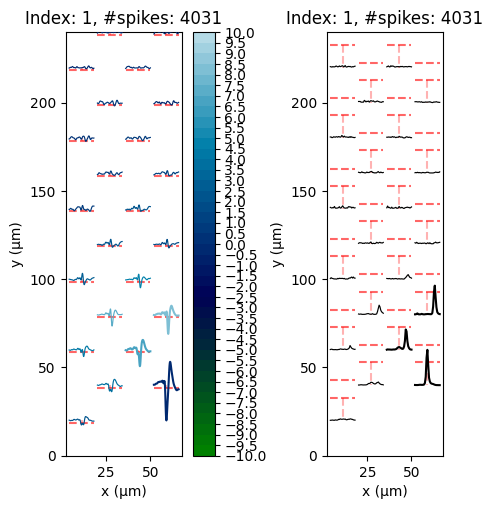

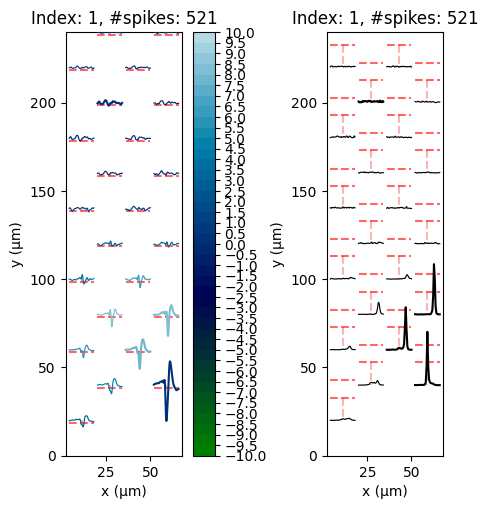

In [72]:
ks_unit = all_ks_units[IDX]
prop_unit = all_prop_units[IDX]
## 
amp_kwargs, prob_kwargs = F.plot_elec_probs(ks_unit)
plt.show()
F.plot_elec_probs(prop_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.show()

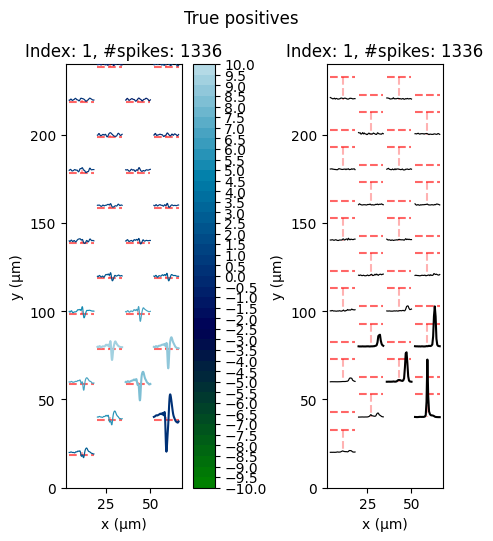

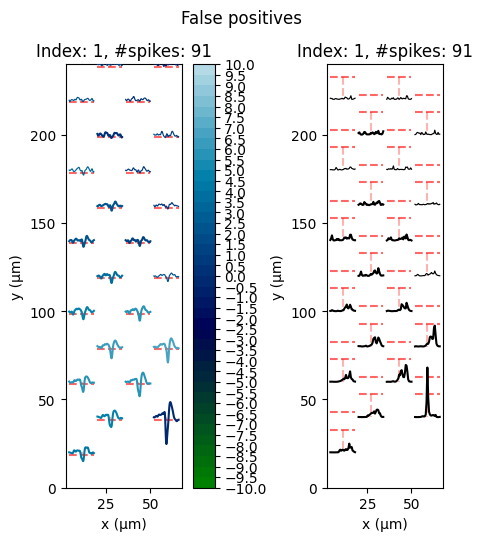

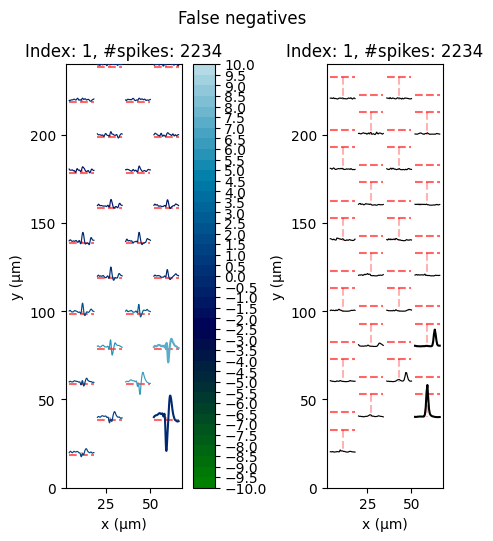

In [20]:
F.plot_elec_probs(prop_and_ks_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("True positives")
plt.show()

F.plot_elec_probs(prop_only_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("False positives")
plt.show()

F.plot_elec_probs(ks_only_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("False negatives")
plt.show()

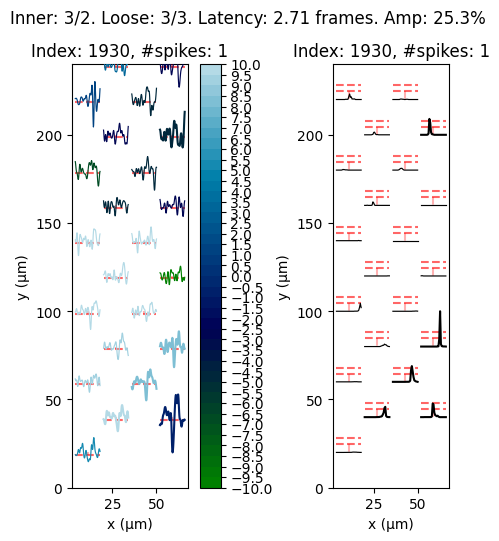

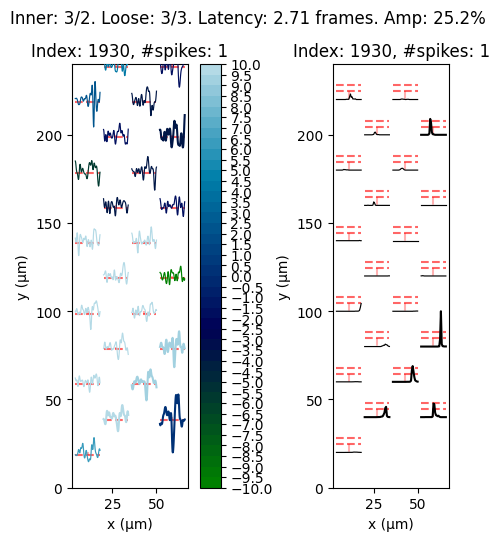

In [136]:
SPIKE_IDX = 1930
##
time = ks_only_units[IDX].spike_train[SPIKE_IDX]
F.plot_seq_spike_overlap(seq, time, SPIKE_IDX)
plt.show()

F.plot_seq_spike_overlap(seq, 207257.033333, SPIKE_IDX)
plt.show()


In [ ]:
F.assign_spikes([deepcopy(seq)], TRAINING_MS,
                interelec=True, only_max_amps=False,
                verbose=True)

In [125]:
test = F.setup_cluster(deepcopy(all_ks_sequences[1]))
test = np.sort(test)
print(np.mean(test))
print(np.mean(test[round(0.2*len(test)):-round(0.2*len(test))]))
print(np.median(test))

0.10014746770508275
0.02079222851897385
0.007289761388122044


In [84]:
all_ks_sequences[1].comp_elecs

[1, 2, 3, 4, 5, 6, 7, 9]

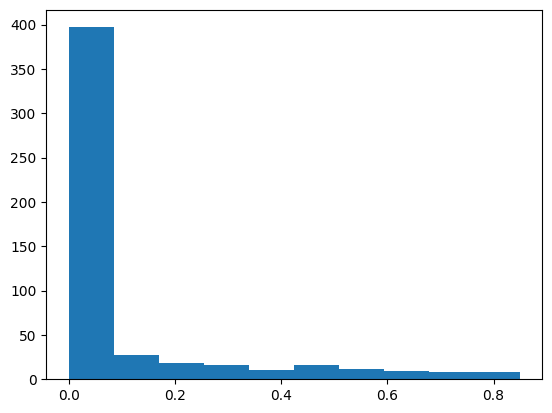

In [81]:
plt.hist(test)
plt.show()

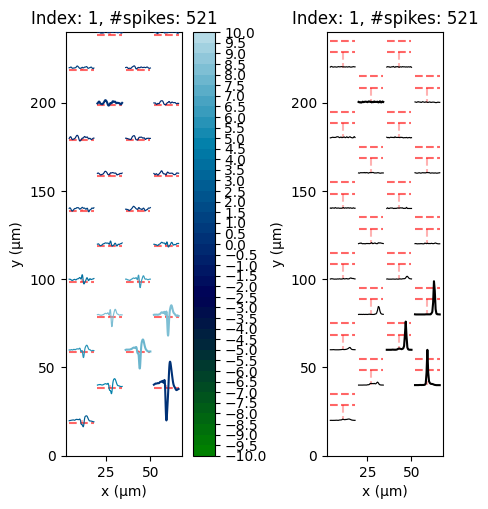

In [93]:
F.plot_elec_probs(seq)
plt.show()

In [106]:
seq.comp_elecs

[1, 2, 3, 4, 5, 6, 7, 9]

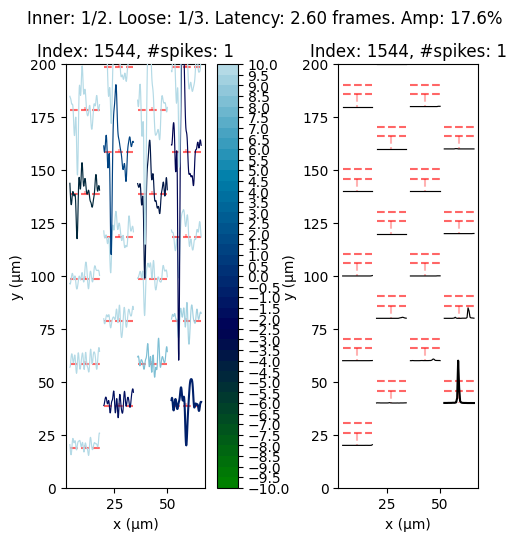

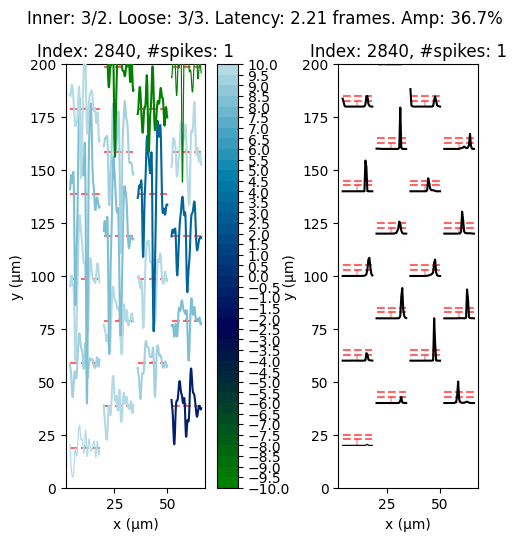

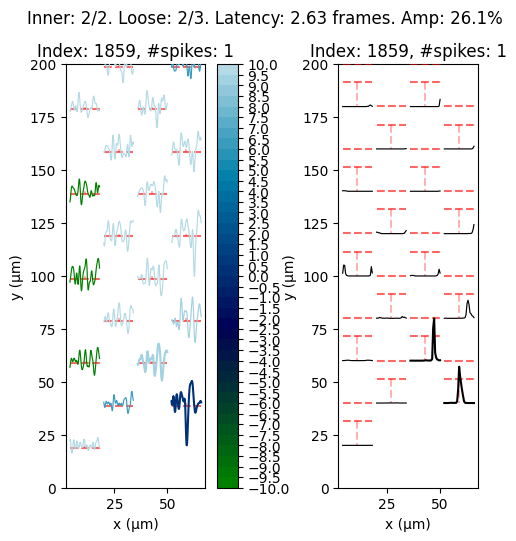

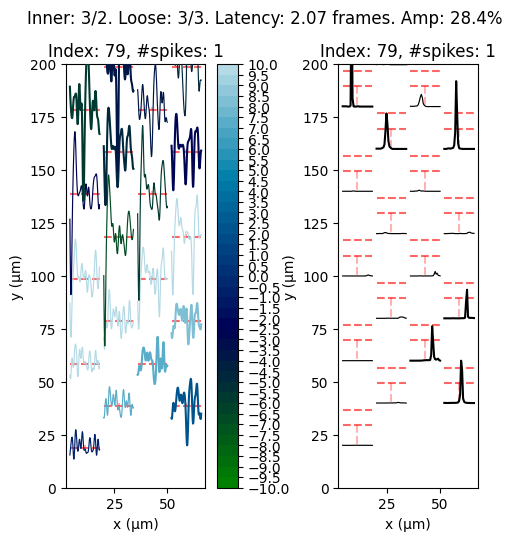

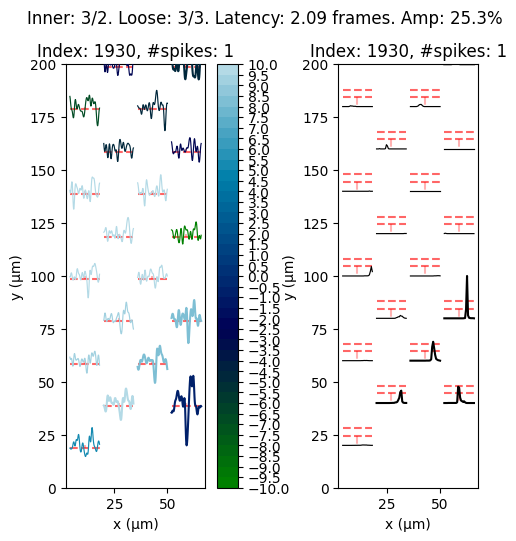

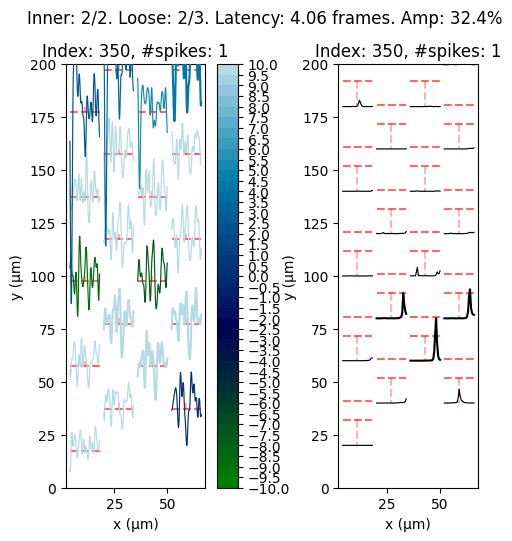

In [ ]:
np.random.seed(100)

seq = all_ks_sequences[IDX]
ks_only = ks_only_units[IDX]

for idx in np.random.choice(len(ks_only.spike_train), 6):
    time = ks_only.spike_train[idx]
    F.plot_seq_spike_overlap(seq, time, idx)
    plt.show()

In [ ]:
seq = all_ks_sequences[IDX]

latency_diffs = []
amp_median_diffs = []
for time in tqdm(ks_only_units[IDX].spike_train):
    latency_diff, amp_median_diff = F.get_seq_spike_overlap(seq, time)
    latency_diffs.append(latency_diff)
    amp_median_diffs.append(amp_median_diff)

100%|██████████| 3336/3336 [00:14<00:00, 229.64it/s]


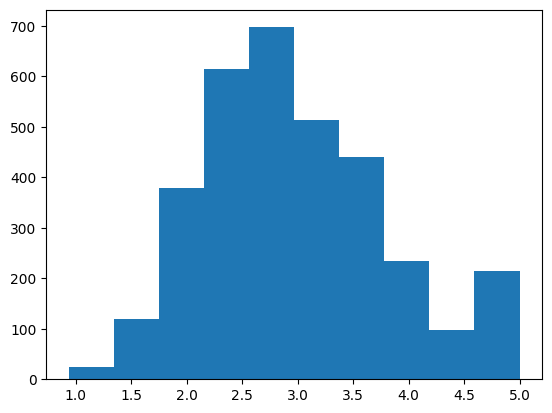

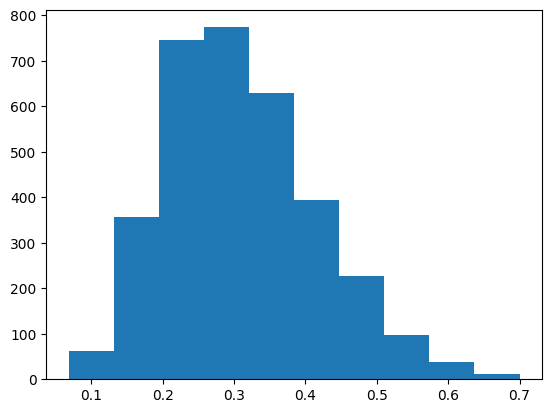

In [ ]:
plt.hist(latency_diffs)
plt.show()
plt.hist(amp_median_diffs)
plt.show()

In [ ]:
sequence = all_ks_sequences[IDX]
count = 0
for spike in ks_unit.spike_train:
    if spike in sequence.time_to_spike_match:
        count += 1
# true_positives, false_positives, false_negatives = Comparison.get_matching_events(ks_unit.spike_train, prop_unit.spike_train)
detectable_times = list(sequence.time_to_spike_match.keys())  # All spikes that can be detected by RT-Sort (detected on at least two elecs by DL model)
detectable_times = np.sort(detectable_times)

# Get ks's closest spike match in time_to_spike_match (upper bound of #matches, i.e. only requirement is DL model detecting on at least two elecs)
max_num_matches = 0  
for ks_spike in ks_unit.spike_train:
    _, prop_spike = utils.find_closest(detectable_times, ks_spike)
    if np.abs(prop_spike - ks_spike) <= OVERLAP_TIME:
        max_num_matches += 1
print(f"Maximum #matches: {max_num_matches}")

Maximum #matches: 2761


In [ ]:
print(f"All stringnet + >=1 loose DL detections:", len(detectable_times))

All stringnet + >=1 loose DL detections: 10829


## Full run all

In [19]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1

%load_ext autoreload

env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from copy import deepcopy
from importlib import reload
from multiprocessing import Pool
import shutil
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

# Only for testing
from diptest import diptest

%autoreload 2
from src import utils, recording
from src.run_alg import si_rec13 as F  # This forces you to manually reload every time modification happens (prevents forgetfulness errors)
from src.sorters.base import Unit
# Load recording
# PATCH_ROOT_PATH = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602")
# PATCH_PATHS = [
#     PATCH_ROOT_PATH / "patch_rec_cell2.raw.h5",
#     PATCH_ROOT_PATH / "patch_rec_cell3.raw.h5",
#     PATCH_ROOT_PATH / "patch_rec_cell4.raw.h5",
#     PATCH_ROOT_PATH / "patch_rec_cell6A.raw.h5",
#     PATCH_ROOT_PATH / "patch_rec_cell6B.raw.h5",
#     PATCH_ROOT_PATH / "patch_rec_cell7.raw.h5"
# ]
# PATCH = '/data/MEAprojects/primary_mouse/patch_ground_truth/181115/1916/MEA_rec_patch_cell1.raw.h5 
# PATCH = "/data/MEAprojects/primary_mouse/patch_ground_truth/190412/2051/MEA_pre_rec.raw.h5"
# PATCH = "/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/patch_rec_cell2.raw.h5"
##

for PATCH in [
    "/data/MEAprojects/primary_mouse/patch_ground_truth/190614/2047/MEA_rec_patch_cell3.raw.h5",
    "/data/MEAprojects/primary_mouse/patch_ground_truth/191113/2179/MEA_rec_patch_cell2.raw.h5",
    "/data/MEAprojects/primary_mouse/patch_ground_truth/210226/3117/pre_rec.raw.h5"
              ]:
    
    try:
        PATCH_PATHS = [Path(PATCH)]
        PATCH_ROOT = PATCH_PATHS[0].parent


        # PATCH_ROOT = "/data/MEAprojects/primary_mouse/patch_ground_truth/181115/1916"
        # PATCH_PATHS = [file for file in Path(PATCH_ROOT).iterdir() if str(file).strip().endswith(".h5")]

        from spikeinterface.extractors import MaxwellRecordingExtractor
        from spikeinterface import concatenate_recordings

        recordings = []
        patch_start_min = 0
        for patch_path in PATCH_PATHS:
            patch = MaxwellRecordingExtractor(patch_path)
            
            # Only select valid channels
            elec_locs = patch.get_channel_locations()
            valid_ids = [id for i, id in enumerate(patch.get_channel_ids()) if np.all(elec_locs[i] != -1)]
            patch = patch.channel_slice(valid_ids, list(range(len(valid_ids))))
            
            # filt_patch = scale(patch, patch.get_channel_gains(), patch.get_channel_offsets(), dtype="float16")
            # filt_patch = bandpass_filter(patch, freq_min=300, freq_max=3000, dtype="float16")
            duration = patch.get_total_duration()/60
            print(f"{patch_path.name.split('.')[0]}: duration: {duration:.2f} min, {patch_start_min:.2f}-{patch_start_min+duration:.2f} min")
            patch_start_min += duration
            recordings.append(patch)
            
            # print(len(valid_ids))
            
        RECORDING = concatenate_recordings(recordings)
        SAMP_FREQ = round(RECORDING.get_sampling_frequency() / 1000)  # kHz
        NUM_ELECS = RECORDING.get_num_channels()
        ELEC_LOCS = RECORDING.get_channel_locations()

        assert SAMP_FREQ <= 35, "SAMP_FREQ must be in kHz"
        if SAMP_FREQ not in {20, 30}:
            print("NEED TO CHANGE FRONT_BUFFER AND OUTPUT_WINDOW_HALF_SIZE TO MODEL'S VALUES")
        if RECORDING.get_total_duration() >= 5 * 60:  # Recording is greater than five minutes
            training_duration_ms = recordings[0].get_total_samples() / recordings[0].get_sampling_frequency() * 1000
            TRAINING_MS = (training_duration_ms - 5*60*1000, training_duration_ms)  # Last 5 minute of first patch
        else:
            TRAINING_MS = (0, RECORDING.get_total_duration() * 1000)
            
        TESTING_MS = (-1, -1)  # Not used for patch recordings
        # TESTING_MS = (training_duration_ms, RECORDING.get_total_duration() * 1000)  # 5 min to 10 min in recording (in ms)
        TRACES_TRAINING_MS = (50, 5*60*1000)  # Rel to scaled_traces
        ROOT_PATH_MODEL = PATCH_ROOT / "rt_sort/dl_model/230101" 
        ROOT_PATH_MODEL.mkdir(exist_ok=True, parents=True)

        MODEL_PATH = Path("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/5118/230101_135307_305876")

        STRINGENT_THRESH = 0.275
        STRINGENT_THRESH_LOGIT = F.sigmoid_inverse(STRINGENT_THRESH)
        LOOSE_THRESH = 0.1 
        LOOSE_THRESH_LOGIT = F.sigmoid_inverse(LOOSE_THRESH)

        # MODEL_INFERENCE_SCALING = 0.3933868408203125  #  /data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602
        # MODEL_INFERENCE_SCALING = 1.26  # /data/MEAprojects/primary_mouse/patch_ground_truth/181115/1916
        TRAINING_MEDIAN = 12.6  # MODEL_INFERENCE_SCALING = TRAINING_MEDIAN / 50ms_median_of_recording

        FRONT_BUFFER = round(2*SAMP_FREQ)
        OUTPUT_WINDOW_HALF_SIZE = round(3*SAMP_FREQ)

        ## No user inputs below
        SCALED_TRACES_PATH = ROOT_PATH_MODEL / "scaled_traces.npy"

        MODEL_TRACES_PATH = ROOT_PATH_MODEL / "model_traces.npy"
        MODEL_OUTPUTS_PATH = ROOT_PATH_MODEL / "model_outputs.npy" 

        ALL_CROSSINGS_PATH  = ROOT_PATH_MODEL / "all_crossings.npy"
        ELEC_CROSSINGS_IND_PATH = ROOT_PATH_MODEL / "elec_crossings_ind.npy"
        F.RECORDING = RECORDING
        F.NUM_ELECS = NUM_ELECS
        F.ELEC_LOCS = ELEC_LOCS
        F.SAMP_FREQ = SAMP_FREQ
        F.FRONT_BUFFER = FRONT_BUFFER
        F.save_traces_mea(PATCH_PATHS[0], SCALED_TRACES_PATH, start_ms=TRAINING_MS[0], end_ms=TRAINING_MS[1])
        from src.run_alg.model import ModelSpikeSorter
        model = ModelSpikeSorter.load(MODEL_PATH)
        model.compile(NUM_ELECS, MODEL_PATH)
        # Get MODEL_INFERENCE_SCALING
        import scipy
        window = np.load(SCALED_TRACES_PATH, mmap_mode="r")[:, :round(50*SAMP_FREQ)]

        iqrs = scipy.stats.iqr(window, axis=1)
        median = np.median(iqrs)
        print(f"50ms median: {median}")
        F.MODEL_INFERENCE_SCALING = TRAINING_MEDIAN / median
        print(f"Model inference scaling: {F.MODEL_INFERENCE_SCALING}")

        F.run_dl_model(MODEL_PATH, SCALED_TRACES_PATH, MODEL_TRACES_PATH, MODEL_OUTPUTS_PATH)
        F.NUM_ELECS = NUM_ELECS
        F.SAMP_FREQ = SAMP_FREQ
        F.FRONT_BUFFER = FRONT_BUFFER
        F.STRINGENT_THRESH = STRINGENT_THRESH
        F.STRINGENT_THRESH_LOGIT = STRINGENT_THRESH_LOGIT
        F.extract_crossings(MODEL_OUTPUTS_PATH, ALL_CROSSINGS_PATH, ELEC_CROSSINGS_IND_PATH)
        # No user inputs here. Run after running DL model
        ALL_CLOSEST_ELECS = []
        for elec in range(NUM_ELECS):
            elec_ind = []
            dists = []
            x1, y1 = ELEC_LOCS[elec]
            for elec2 in range(RECORDING.get_num_channels()):
                if elec == elec2:
                    continue
                x2, y2 = ELEC_LOCS[elec2]
                dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
                elec_ind.append(elec2)
            order = np.argsort(dists)
            ALL_CLOSEST_ELECS.append(np.array(elec_ind)[order])   
        # 
        TRACES = np.load(MODEL_TRACES_PATH, mmap_mode="r")
        FILT_TRACES = np.load(SCALED_TRACES_PATH, mmap_mode="r")  # called FILT_TRACES, but these are not actually filtered
        OUTPUTS = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")
        ALL_CROSSINGS = np.load(ALL_CROSSINGS_PATH, allow_pickle=True)
        ELEC_CROSSINGS_IND = np.load(ELEC_CROSSINGS_IND_PATH, allow_pickle=True)

        ALL_CROSSINGS = [tuple(cross) for cross in ALL_CROSSINGS]
        ELEC_CROSSINGS_IND = [tuple(ind) for ind in ELEC_CROSSINGS_IND]  # [(elec's cross times ind in all_crossings)]
        # Set global variables in .py
        reload(F)

        F.RECORDING = RECORDING
        F.MEA = True
        F.STRINGENT_THRESH = STRINGENT_THRESH
        F.STRINGENT_THRESH_LOGIT = STRINGENT_THRESH_LOGIT
        F.LOOSE_THRESH = LOOSE_THRESH
        F.LOOSE_THRESH_LOGIT = LOOSE_THRESH_LOGIT

        # F.CHANS_RMS = CHANS_RMS
        F.SAMP_FREQ = SAMP_FREQ
        F.NUM_ELECS = NUM_ELECS
        F.ELEC_LOCS = ELEC_LOCS

        F.ALL_CLOSEST_ELECS = ALL_CLOSEST_ELECS

        F.FRONT_BUFFER = FRONT_BUFFER
        F.OUTPUT_WINDOW_HALF_SIZE = OUTPUT_WINDOW_HALF_SIZE

        F.N_BEFORE = F.N_AFTER = round(0.3 * SAMP_FREQ) # round(0.5 * SAMP_FREQ)  # Window for looking for electrode codetections
        F.MIN_ELECS_FOR_ARRAY_NOISE = F.MIN_ELECS_FOR_SEQ_NOISE = max(100, round(0.1 * NUM_ELECS))
        F.PRE_MEDIAN_FRAMES = round(50 * SAMP_FREQ)

        # If doing on new recording, these should be set after ## Full run - DL model
        F.TRACES = TRACES
        F.OUTPUTS = OUTPUTS
        F.ALL_CROSSINGS = ALL_CROSSINGS
        F.ELEC_CROSSINGS_IND = ELEC_CROSSINGS_IND

        # Different parameters for MEA
        F.MIN_AMP_DIST_P = -1
        F.MAX_AMP_MEDIAN_DIFF_SPIKES = F.MAX_AMP_MEDIAN_DIFF_SEQUENCES = 0.65
        F.MAX_LATENCY_DIFF_SPIKES = F.MAX_LATENCY_DIFF_SEQUENCES = 3.5
        F.CLIP_LATENCY_DIFF = 7
        F.CLIP_AMP_MEDIAN_DIFF = 1.3
        F.MAX_ROOT_AMP_MEDIAN_STD = 2.5
        # ROOT_PATH = Path("/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/240303")
        ROOT_PATH = PATCH_ROOT / "rt_sort/240303"
        ROOT_PATH.mkdir(exist_ok=True, parents=True)

        MIN_SPIKES = max(10, 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000)
        all_clusters = F.form_all_clusters(TRACES_TRAINING_MS)
        utils.pickle_dump(all_clusters, ROOT_PATH / "all_clusters.pickle")
        all_clusters = utils.pickle_load(ROOT_PATH / "all_clusters.pickle")
        all_clusters_reassigned = F.reassign_spikes(all_clusters, TRACES_TRAINING_MS, MIN_SPIKES)
        utils.pickle_dump(all_clusters_reassigned, ROOT_PATH / "all_clusters_reassigned.pickle")
        all_clusters_reassigned = utils.pickle_load(ROOT_PATH / "all_clusters_reassigned.pickle")
        intra_merged_clusters = F.intra_merge(all_clusters_reassigned) 
        trained_sequences = F.inter_merge(intra_merged_clusters, MIN_SPIKES)
        utils.pickle_dump(trained_sequences, ROOT_PATH / "trained_sequences.pickle")
        trained_sequences = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")
        # DATE = "240303"
        # INTER_DATE = DATE #"240219"  # For when using inter of different day
        # SEQUENCES = utils.pickle_load(f"/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/{DATE}/trained_sequences.pickle")
        SEQUENCES = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")

        # for cluster in SEQUENCES:  # In case changed elec thresholds after forming
        #     cluster.min_loose_detections = max(F.MIN_LOOSE_DETECTIONS_N, F.MIN_LOOSE_DETECTIONS_R_SPIKES * len(cluster.loose_elecs))

        # 5, 2, 1
        # RECORDING_PATHS = np.array(PATCH_PATHS)[1:]  # rec_name for RECORDING_PATHS[i] is RECORDING_PATHS[i].name.split(".")[0]
        RECORDING_PATHS = [file for file in Path(PATCH_ROOT).iterdir() if str(file).strip().endswith(".h5") and file != PATCH_PATHS[0]]

        # intermediate data will be stored in folder INTER_ROOT_PATH  / RECORDING_PATHS[i]
        # spike times will be stored at SPIKE_TIMES_ROOT_PATH / RECORDING_PATHS[i].npy

        # INTER_ROOT_PATH = Path(f"/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/{INTER_DATE}/inter")  
        # SPIKE_TIMES_ROOT_PATH = Path(f"/data/MEAprojects/primary_mouse/patch_ground_truth/200724/2602/rt_sort/{DATE}/all_spike_trains")  
        INTER_ROOT_PATH = ROOT_PATH / "inter"
        SPIKE_TIMES_ROOT_PATH = ROOT_PATH / "all_spike_trains"

        DELETE_INTER = True  # whether to delete intermediate data

        # Plotting for 200724/2602 to find which sequences corresponds to cell
        # for seq in F.get_nearby_clusters(SEQUENCES, 2600, 600, 50):  # around cell 7
        #     F.plot_elec_probs(seq)
        #     plt.suptitle("Pre-recording")
        #     plt.show()
        # for seq in F.get_nearby_clusters(SEQUENCES, 1960, 500, 50):  # around cell 4
        #     F.plot_elec_probs(seq)
        #     plt.suptitle("Pre-recording")
        #     plt.show()
        # for seq in F.get_nearby_clusters(SEQUENCES, 1960, 420, 50):  # around cell 2
        #     F.plot_elec_probs(seq)
        #     plt.suptitle("Pre-recording")
        #     plt.show()
        for rec_path in RECORDING_PATHS:    
            # Setup paths
            rec_path = Path(rec_path)
            rec_name = rec_path.name.split(".")[0]
            
            print(f"\nStarting on {rec_name}")
            
            spike_times_path = SPIKE_TIMES_ROOT_PATH / f"{rec_name}.npy"
            spike_times_path.parent.mkdir(exist_ok=True, parents=True)
            
            inter_path = INTER_ROOT_PATH / rec_name
            inter_path.mkdir(exist_ok=True, parents=True)
            scaled_traces_path = inter_path / "scaled_traces.npy"
            model_traces_path = inter_path / "model_traces.npy"
            model_outputs_path = inter_path / "model_outputs.npy"

            F.save_traces_mea(rec_path, scaled_traces_path, samp_freq=SAMP_FREQ)
            F.run_dl_model(MODEL_PATH, scaled_traces_path, model_traces_path, model_outputs_path)
            F.TRACES = np.load(model_traces_path, mmap_mode="r")
            F.OUTPUTS = np.load(model_outputs_path, mmap_mode="r")
            print("Assigning spikes ...")
            all_spike_trains = F.assign_spikes_torch(SEQUENCES, time_frame_ms=None, return_spikes=True)
            torch.cuda.empty_cache()
            
            np.save(spike_times_path, np.array(all_spike_trains, dtype=object))
            
            if DELETE_INTER:
                shutil.rmtree(inter_path)
    except Exception as e:
        print(e)
        torch.cuda.empty_cache()

MEA_rec_patch_cell3: duration: 2.31 min, 0.00-2.31 min
'lsb' not found in 'settings'. Setting gain to uV to 1
Alllocating memory for traces ...
Extracting traces ...


100%|██████████| 28/28 [00:22<00:00,  1.24it/s]
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
Try decreasing the workspace size with IBuilderConfig::setMemoryPoolLimit().
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
Try decreasing the workspace size with IBuilderConfig::setMemoryPoolLimit().
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [

50ms median: 8.0
Model inference scaling: 1.575
Loading DL model ...
Running model ...


100%|██████████| 817/817 [05:16<00:00,  2.58it/s]


404 sequences before merging


100%|██████████| 76/76 [00:02<00:00, 36.89it/s]


111 sequences after first merging

Merged 18 with 6
Latency diff: 0.05. Amp median diff: 0.05
Amp dist p-value 0.4067
#spikes:
Merge base: 877, Add: 525, Overlaps: 0
After merging: 1402

Merged 15 with 82
Latency diff: 0.11. Amp median diff: 0.06
Amp dist p-value 0.7603
#spikes:
Merge base: 282, Add: 251, Overlaps: 0
After merging: 533

Merged 54 with 83
Latency diff: 0.04. Amp median diff: 0.07
Amp dist p-value 0.8691
#spikes:
Merge base: 850, Add: 423, Overlaps: 0
After merging: 1269

Merged 92 with 96
Latency diff: 0.14. Amp median diff: 0.06
Amp dist p-value 0.1742
#spikes:
Merge base: 105, Add: 546, Overlaps: 0
After merging: 650

Merged 17 with 26
Latency diff: 0.15. Amp median diff: 0.06
Amp dist p-value 0.7725
#spikes:
Merge base: 998, Add: 1043, Overlaps: 0
After merging: 2041

Merged 46 with [17, 26]
Latency diff: 0.22. Amp median diff: 0.05
Amp dist p-value 0.0269
#spikes:
Merge base: 721, Add: 2041, Overlaps: 0
After merging: 2761

Merged [54, 83] with 45
Latency diff: 0.12

100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


Loading DL model ...
Running model ...


100%|██████████| 11244/11244 [00:21<00:00, 513.05it/s]


Assigning spikes ...


100%|██████████| 12484/12484 [00:12<00:00, 998.93it/s] 


MEA_rec_patch_cell2: duration: 24.39 min, 0.00-24.39 min
'lsb' not found in 'settings'. Setting gain to uV to 1
Alllocating memory for traces ...
Extracting traces ...


100%|██████████| 60/60 [00:50<00:00,  1.20it/s]
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
Try decreasing the workspace size with IBuilderConfig::setMemoryPoolLimit().
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
Try decreasing the workspace size with IBuilderConfig::setMemoryPoolLimit().
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [

50ms median: 9.0
Model inference scaling: 1.4
Loading DL model ...
Running model ...


 89%|████████▉ | 816/913 [00:32<00:02, 38.60it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
100%|██████████| 913/913 [00:50<00:00, 18.01it/s]


234 sequences before merging


100%|██████████| 38/38 [00:01<00:00, 31.71it/s]


52 sequences after first merging

Merged 6 with 17
Latency diff: 0.12. Amp median diff: 0.11
Amp dist p-value 0.7104
#spikes:
Merge base: 347, Add: 78, Overlaps: 0
After merging: 421

Merged 19 with [6, 17]
Latency diff: 0.09. Amp median diff: 0.13
Amp dist p-value 1.2812
#spikes:
Merge base: 201, Add: 421, Overlaps: 0
After merging: 622

Merged 41 with 32
Latency diff: 0.07. Amp median diff: 0.16
Amp dist p-value 1.2432
#spikes:
Merge base: 64, Add: 97, Overlaps: 1
After merging: 160

Merged 5 with 37
Latency diff: 0.31. Amp median diff: 0.18
Amp dist p-value 0.3838
#spikes:
Merge base: 133, Add: 88, Overlaps: 2
After merging: 218

Merged 26 with 18
Latency diff: 0.52. Amp median diff: 0.17
Amp dist p-value 0.8984
#spikes:
Merge base: 166, Add: 55, Overlaps: 0
After merging: 211

Merged 20 with 16
Latency diff: 0.60. Amp median diff: 0.18
Amp dist p-value 1.1504
#spikes:
Merge base: 77, Add: 42, Overlaps: 1
After merging: 111

Merged 48 with 44
Latency diff: 0.56. Amp median diff: 0.2

100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


Loading DL model ...
Running model ...


100%|██████████| 30904/30904 [01:10<00:00, 440.14it/s]


Assigning spikes ...


100%|██████████| 34329/34329 [00:36<00:00, 941.56it/s] 



Starting on MEA_rec_patch_cell3
'lsb' not found in 'settings'. Setting gain to uV to 1
Alllocating memory for traces ...
Extracting traces ...


100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


Loading DL model ...
Running model ...


100%|██████████| 15454/15454 [00:32<00:00, 471.60it/s]


Assigning spikes ...


100%|██████████| 17162/17162 [00:18<00:00, 908.08it/s] 


pre_rec: duration: 19.33 min, 0.00-19.33 min
'lsb' not found in 'settings'. Setting gain to uV to 1
Alllocating memory for traces ...
Extracting traces ...


100%|██████████| 60/60 [00:53<00:00,  1.12it/s]


50ms median: 2.0
Model inference scaling: 6.3
Loading DL model ...
Running model ...


  2%|▏         | 15/995 [00:17<54:19,  3.33s/it]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
  2%|▏         | 18/995 [00:22<36:51,  2.26s/it]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
  2%|▏         | 19/995 [00:23<29:31,  1.81s/it]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
  2%|▏         | 24/995 [00:24<09:11,  1.76it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
  8%|▊         | 77/995 [01:17<11:50,  1.29it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python

985 sequences before merging
CUDA out of memory. Tried to allocate 11.12 GiB (GPU 0; 23.67 GiB total capacity; 11.12 GiB already allocated; 10.64 GiB free; 11.13 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
